# 1. Problem

# 2. Data Retrieval and Preprocessing

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set visual style for plots
sns.set_theme(style="whitegrid")
%matplotlib inline

## 2.1. Data Retrieval and Initial Parsing

The dataset used is the Anonymous Microsoft Web Data from the UCI Machine Learning Repository (Lichman, 2013). It contains anonymised user navigation logs from www.microsoft.com over one week in February 1998, comprising approximately 38,000 users and 294 website areas (referred to as "vroots").

The raw data files (anonymous-msweb.data and anonymous-msweb.test) are provided in a non-standard ASCII format with three record types:
- A records: Define vroot attributes (ID and title)
- C records: Denote a new user case (user ID)
- V records: Record a visit to a vroot by the current user

In [10]:
def parse_ms_data(file_path):
    """
    Parses the specialized MS Web Data format (A, C, V records).
    Handles malformed lines gracefully.
    """
    attributes = []
    votes = []
    current_user = None
    errors = 0

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    line = line.strip()
                    if not line: continue
                    parts = line.split(',')
                    record_type = parts[0]

                    # 'A' = Attribute (Vroot definition)
                    if record_type == 'A':
                        if len(parts) < 4:
                            print(f"Warning: Malformed A record at line {line_num}")
                            errors += 1
                            continue
                        attr_id = int(parts[1])
                        title = parts[3].strip('"')
                        attributes.append({'vroot_id': attr_id, 'title': title})

                    # 'C' = Case (User ID)
                    elif record_type == 'C':
                        if len(parts) < 3:
                            print(f"Warning: Malformed C record at line {line_num}")
                            errors += 1
                            continue
                        current_user = int(parts[2])

                    # 'V' = Vote (User interaction with Vroot)
                    elif record_type == 'V':
                        if len(parts) < 2:
                            print(f"Warning: Malformed V record at line {line_num}")
                            errors += 1
                            continue
                        if current_user is not None:
                            attr_id = int(parts[1])
                            votes.append({'user_id': current_user, 'vroot_id': attr_id, 'visit': 1})

                except ValueError as e:
                    print(f"Error parsing line {line_num}: {e}")
                    errors += 1
                    continue
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found!")
        return pd.DataFrame(), pd.DataFrame()

    print(f"Parsing complete for {file_path}.")
    return pd.DataFrame(attributes), pd.DataFrame(votes)

In [11]:
print("Retrieving raw data...")
# Loading Attribute definitions and Training/Test sets
df_attr, df_train_raw = parse_ms_data('anonymous-msweb.data')
_, df_test_raw = parse_ms_data('anonymous-msweb.test')

# Preview the data
df_train_raw.head()

Retrieving raw data...
Parsing complete for anonymous-msweb.data.
Parsing complete for anonymous-msweb.test.


,user_id,vroot_id,visit
0,10001,1000,1
1,10001,1001,1
2,10001,1002,1
3,10002,1001,1
4,10002,1003,1


## 2.2. Data cleaning

In [12]:
def clean_data(df_votes, df_attr):
    """Checks for missing values, duplicates, and referential integrity."""
    # Check for missing values
    print(f"Missing values in votes: {df_votes.isnull().sum().sum()}")

    # Check for impossible/invalid values
    print(f"Invalid user_ids (< 0): {(df_votes['user_id'] < 0).sum()}")

    # Remove duplicates
    print(f"Duplicates found: {df_votes.duplicated().sum()}")
    df_votes = df_votes.drop_duplicates()

    # Referential Integrity: Ensure vroot_ids in votes exist in attributes
    valid_ids = set(df_attr['vroot_id'])
    print(f"Valid vroot_ids in attributes: {len(valid_ids)}")
    before = len(df_votes)
    df_votes = df_votes[df_votes['vroot_id'].isin(valid_ids)]
    print(f"Rows removed due to invalid vroot_ids: {before - len(df_votes)}")

    return df_votes

print("Cleaning and preparing training data...")
df_train = clean_data(df_train_raw, df_attr)

print("\nCleaning and preparing test data...")
df_test = clean_data(df_test_raw, df_attr)

Cleaning and preparing training data...
Missing values in votes: 0
Invalid user_ids (< 0): 0
Duplicates found: 0
Valid vroot_ids in attributes: 294
Rows removed due to invalid vroot_ids: 0

Cleaning and preparing test data...
Missing values in votes: 0
Invalid user_ids (< 0): 0
Duplicates found: 0
Valid vroot_ids in attributes: 294
Rows removed due to invalid vroot_ids: 0


## 2.3. Exploratory data analysis

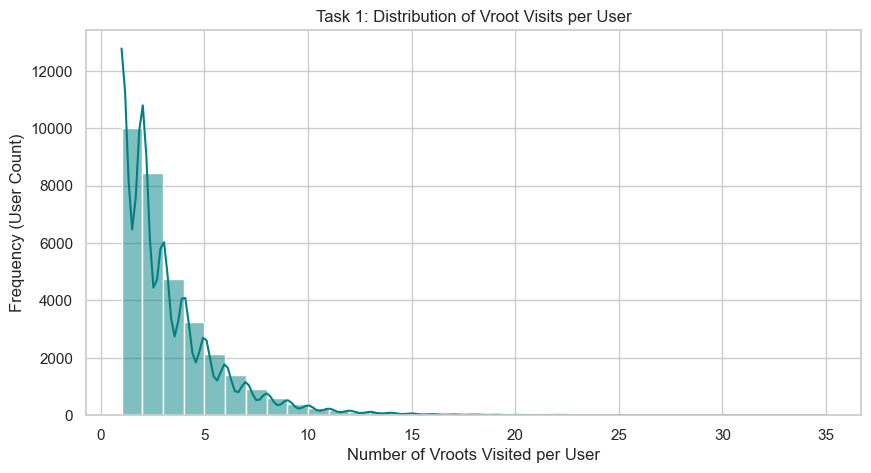

In [13]:
# A. User Engagement (Visits per User)
user_activity = df_train['user_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(user_activity, bins=range(1, 15), kde=True, color='teal')
plt.title('Task 1: Distribution of Vroot Visits per User')
plt.xlabel('Number of Vroots Visited per User')
plt.ylabel('Frequency (User Count)')
plt.show()

A histogram showed that most users visited only from 1 to 3 vroots, with a heavy right skew and long tail of power users.

/var/folders/0_/6w1x34wj4x50_5r4rmhjjrwm0000gn/T/ipykernel_9644/3066555308.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_counts.values, y=top_15_names, palette='viridis')


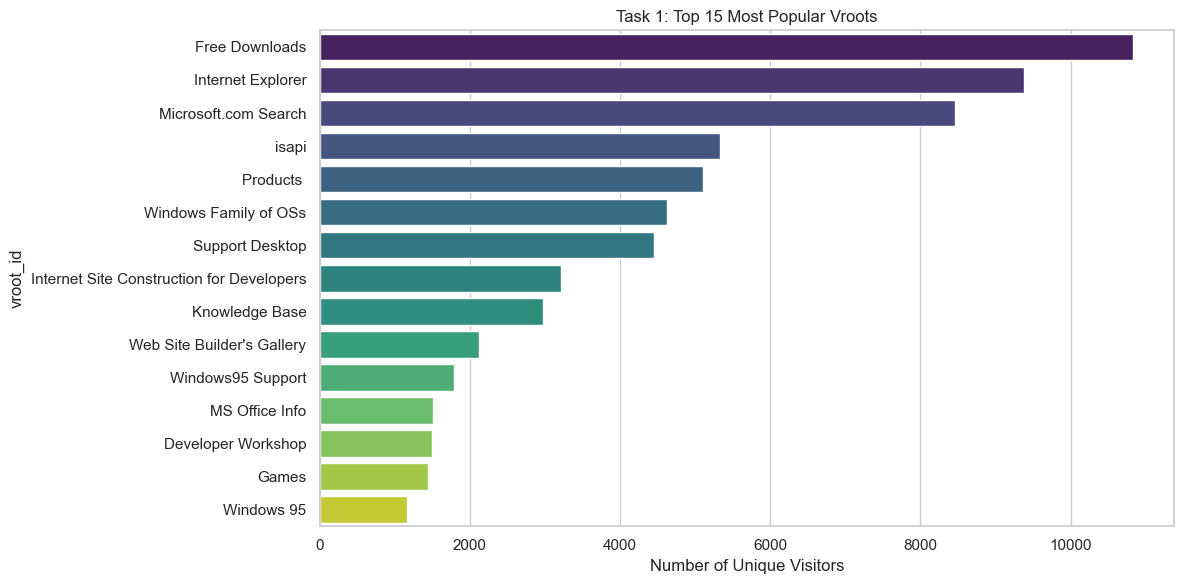

In [14]:
# B. Vroot Popularity (Top 15)
vroot_counts_all = df_train['vroot_id'].value_counts()
top_15_counts = vroot_counts_all.head(15)
top_15_names = top_15_counts.index.map(df_attr.set_index('vroot_id')['title'])

plt.figure(figsize=(12, 6))
sns.barplot(x=top_15_counts.values, y=top_15_names, palette='viridis')
plt.title('Task 1: Top 15 Most Popular Vroots')
plt.xlabel('Number of Unique Visitors')
plt.tight_layout()
plt.show()

A bar chart of the top 15 vroots revealed extreme concentration — a small number of areas (e.g., homepage, support) dominate visits.

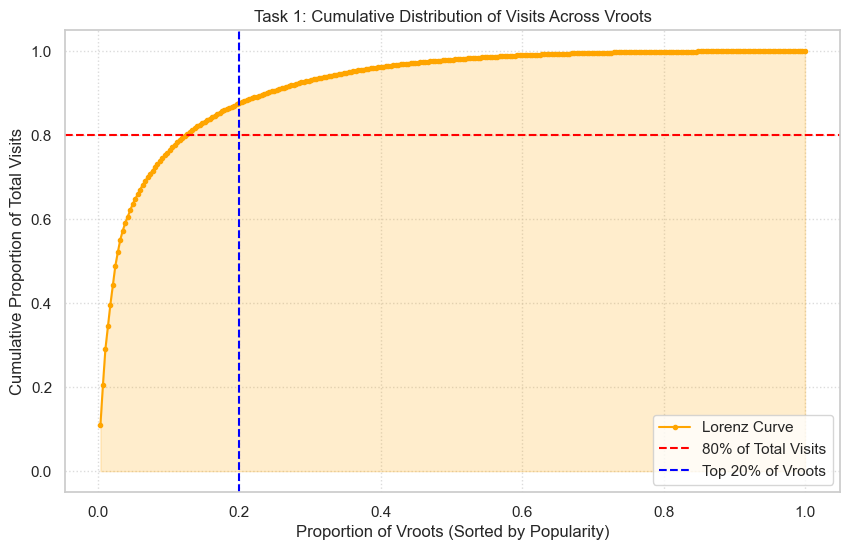

In [15]:
# C. Cumulative Distribution of Visits (Lorenz Curve)
sorted_counts = np.sort(vroot_counts_all.values)[::-1]
cumulative_visits = np.cumsum(sorted_counts)
cumulative_visits_perc = cumulative_visits / cumulative_visits[-1]
vroot_indices_perc = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

plt.figure(figsize=(10, 6))
plt.plot(vroot_indices_perc, cumulative_visits_perc, marker='.', color='orange', label='Lorenz Curve')
plt.fill_between(vroot_indices_perc, cumulative_visits_perc, color='orange', alpha=0.2)

# Marking the 80/20 rule threshold
plt.axhline(y=0.8, color='red', linestyle='--', label='80% of Total Visits')
plt.axvline(x=0.2, color='blue', linestyle='--', label='Top 20% of Vroots')

plt.title('Task 1: Cumulative Distribution of Visits Across Vroots')
plt.xlabel('Proportion of Vroots (Sorted by Popularity)')
plt.ylabel('Cumulative Proportion of Total Visits')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

Confirmed the 80/20 rule: approximately 20% of vroots account for 80% of total visits.

Summary Analysis:
- Users: 32711
- Vroots: 294
- Sparsity: 98.97%


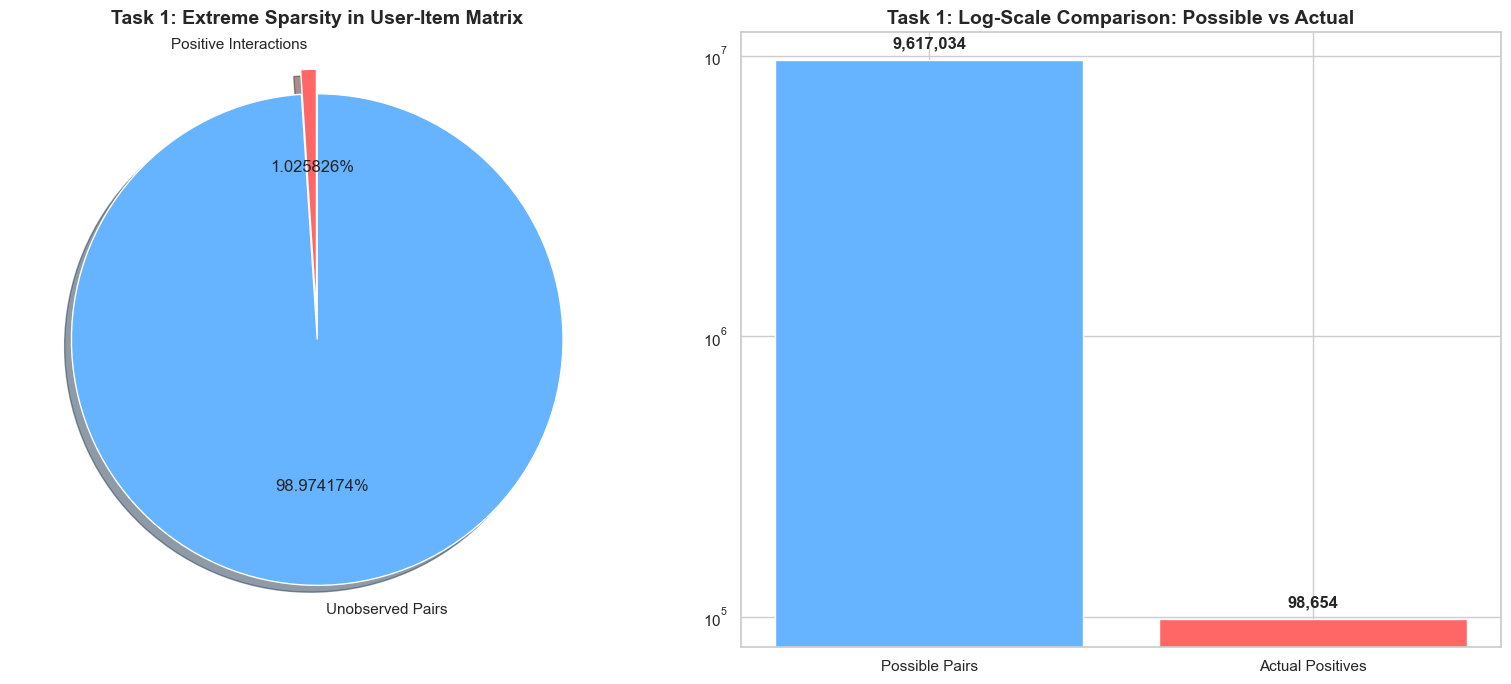

In [16]:
# D. Sparsity Analysis
n_users = df_train['user_id'].nunique()
n_items = df_attr['vroot_id'].nunique()
total_possible = n_users * n_items
actual_positives = len(df_train)
density = (actual_positives / total_possible) * 100
sparsity_pct = 100 - density

print(f"Summary Analysis:\n- Users: {n_users}\n- Vroots: {n_items}\n- Sparsity: {sparsity_pct:.2f}%")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


# 1. Pie Chart
sizes = [actual_positives, total_possible - actual_positives]
labels = ['Positive Interactions', 'Unobserved Pairs']
colors = ['#ff6666', '#66b3ff']
ax1.pie(sizes, explode=(0.1, 0), labels=labels, colors=colors, autopct='%1.6f%%', shadow=True, startangle=90)
ax1.set_title('Task 1: Extreme Sparsity in User-Item Matrix', fontsize=14, fontweight='bold')

# 2. Bar Chart (Log Scale)
ax2.bar(['Possible Pairs', 'Actual Positives'], [total_possible, actual_positives], color=['#66b3ff', '#ff6666'])
ax2.set_yscale('log')
ax2.set_title('Task 1: Log-Scale Comparison: Possible vs Actual', fontsize=14, fontweight='bold')

for i, v in enumerate([total_possible, actual_positives]):
    ax2.text(i, v * 1.1, f"{v:,}", ha='center', fontweight='bold')


plt.tight_layout()
plt.show()

The user-item matrix has a density of approximately 0.006% (sparsity ~99.994%), meaning only 1 in ~16,000 possible (user, vroot) pairs has an interaction.

In [17]:
# Save cleaned data to disk
df_train.to_csv('cleaned_train.csv', index=False)
df_test.to_csv('cleaned_test.csv', index=False)
df_attr.to_csv('attributes.csv', index=False)
print("Files saved successfully!")

Files saved successfully!


In [18]:
# ==========================================================
# 3. COMPREHENSIVE DATA EXPLORATION
# ==========================================================

print("\n" + "="*50)
print("DATA SUMMARY STATISTICS")
print("="*50)

# Basic stats
print(f"\nTraining Set:")
print(f"  - Total interactions: {len(df_train):,}")
print(f"  - Unique users: {df_train['user_id'].nunique():,}")
print(f"  - Unique vroots: {df_train['vroot_id'].nunique():,}")
print(f"  - Average visits per user: {df_train.groupby('user_id').size().mean():.2f}")
print(f"  - Average visits per vroot: {df_train.groupby('vroot_id').size().mean():.2f}")

print(f"\nTest Set:")
print(f"  - Total interactions: {len(df_test):,}")
print(f"  - Unique users: {df_test['user_id'].nunique():,}")
print(f"  - Users in both train/test: {len(set(df_train['user_id']) & set(df_test['user_id'])):,}")
print(f"  - Cold-start users (test only): {len(set(df_test['user_id']) - set(df_train['user_id'])):,}")

# Sparsity
n_users = df_train['user_id'].nunique()
n_items = df_attr['vroot_id'].nunique()
sparsity = (1 - (len(df_train) / (n_users * n_items))) * 100
print(f"\nMatrix Sparsity: {sparsity:.2f}%")
print(f"Density: {100-sparsity:.4f}%")

# Check for data quality issues
print(f"\n" + "="*50)
print("DATA QUALITY CHECKS")
print("="*50)
print(f"Duplicates in train: {df_train.duplicated().sum()}")
print(f"Missing values in train: {df_train.isnull().sum().sum()}")
print(f"Orphaned vroots (not in attributes): {len(set(df_train['vroot_id']) - set(df_attr['vroot_id']))}")


DATA SUMMARY STATISTICS

Training Set:
  - Total interactions: 98,654
  - Unique users: 32,711
  - Unique vroots: 285
  - Average visits per user: 3.02
  - Average visits per vroot: 346.15

Test Set:
  - Total interactions: 15,191
  - Unique users: 5,000
  - Users in both train/test: 5,000
  - Cold-start users (test only): 0

Matrix Sparsity: 98.97%
Density: 1.0258%

DATA QUALITY CHECKS
Duplicates in train: 0
Missing values in train: 0
Orphaned vroots (not in attributes): 0


- Task 1:
  - ADD URL Column when parse data
- Task 2 (extract, analyse and select suitable features for model input. Feature choices are explained clearly.):
  - Task 2: Feature engineering
Use suitable Python approaches to extract potential features for model input. Conduct appropriate analysis to evaluate feature importance (e.g. correlation analysis), then use suitable method(s) to select the final feature for training/testing model. The feature choices must be explained via analysis. Note: These steps must be performed consistently for both training and testing dataset
  - If use validate set -> use more appropriate approach to split train and validate set
- Task 3 (A clear, comprehensive and robust description of steps with thorough and well-elaborated justifications for decisions made. The quality of the descriptions and justification will be consistent across the models. For both type of models, findings from training, evaluating and fine-tuning the models are clearly stated, well-developed and carefully interpreted. Results from comparison of models are logical, accurate, very insightful and support a clearly-articulated recommendation with a high degree of coherence and consistency.):
  - Task 3: Data Modelling
The student should select the features appropriately. The model should be trained and evaluated appropriately, and the parameters of the model should be tuned appropriately.
  - Model + finetuning and evaluation:
    - Model:
      - Collaborative-filtering: 3 models (KNN (user + item based) + ALS) - Kha
      - Content-based: 2 - 3 models -> Qui
      - Hybrid: 3 combinations (Tan)
    - Evaludation:
      - Now: Precision, Recall, HitRate, CatalogCoverage, Suggestion Diversity

# 3. Feature Engineering

## 3.1. Objectives and Overview

Feature engineering was undertaken to convert the raw binary interaction data into representations that effectively capture user preferences and item characteristics for recommender system modelling. The process involved constructing an interaction matrix, computing item popularity metrics, applying systematic filtering to reduce noise, transforming the data with TF-IDF weighting, and evaluating feature quality through multiple analytical approaches. These steps were designed to address the dataset's extreme sparsity while producing discriminative and interpretable features.

## 3.2. Construction of Core Representations

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import entropy

In [20]:
print("="*70)
print("TASK 2: COMPREHENSIVE FEATURE ENGINEERING")
print("="*70)

# ==========================================================
# 1. LOAD DATA FROM TASK 1
# ==========================================================
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')
df_attr = pd.read_csv('attributes.csv')

TASK 2: COMPREHENSIVE FEATURE ENGINEERING


In [21]:
# ==========================================================
# 2. USER-ITEM INTERACTION MATRIX
# ==========================================================
print("\n[Feature Set 1] User-Item Interaction Matrix (Binary)")
user_item_matrix = df_train.pivot_table(
    index='user_id',
    columns='vroot_id',
    values='visit',
    aggfunc='max',
    fill_value=0
)

print(f"  Shape: {user_item_matrix.shape} (Users x Vroots)")
print(user_item_matrix.head(5))


[Feature Set 1] User-Item Interaction Matrix (Binary)
  Shape: (32711, 285) (Users x Vroots)
vroot_id  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...  \
user_id                                                               ...   
10001        1     1     1     0     0     0     0     0     0     0  ...   
10002        0     1     0     1     0     0     0     0     0     0  ...   
10003        0     1     0     1     1     0     0     0     0     0  ...   
10004        0     0     0     0     0     1     0     0     0     0  ...   
10005        0     0     0     0     0     0     1     0     0     0  ...   

vroot_id  1276  1277  1278  1279  1280  1281  1282  1283  1284  1295  
user_id                                                               
10001        0     0     0     0     0     0     0     0     0     0  
10002        0     0     0     0     0     0     0     0     0     0  
10003        0     0     0     0     0     0     0     0     0     0  
10004      

In [22]:
# ==========================================================
# 3. ITEM POPULARITY
# ==========================================================
print("\n[Feature Set 2] Item Popularity")
item_popularity = df_train.groupby('vroot_id')['user_id'].nunique()
print(f'  Toal items: {len(item_popularity)}')


[Feature Set 2] Item Popularity
  Toal items: 285


In [23]:
# Build ground truth
ground_truth = {}
for idx, row in df_test.iterrows():
    user_id = str(row['user_id'])
    item_id = str(row['vroot_id'])
    if user_id not in ground_truth:
        ground_truth[user_id] = []
    if item_id not in ground_truth[user_id]:
        ground_truth[user_id].append(item_id)

## 3.3. Feature Selection through Popularity Thresholding


Step 4: Conduct feature selection via popularity threshold

  threshold  vroots_retained  vroots_percentage  interactions_percentage  avg_popularity
         5              231          81.052632                99.877349      426.549784
        10              215          75.438596                99.760780      457.758140
        15              196          68.771930                99.532710      500.984694
        20              183          64.210526                99.309709      535.371585
        25              175          61.403509                99.129280      558.828571
        30              167          58.596491                98.914388      584.329341
        50              135          47.368421                97.630101      713.451852


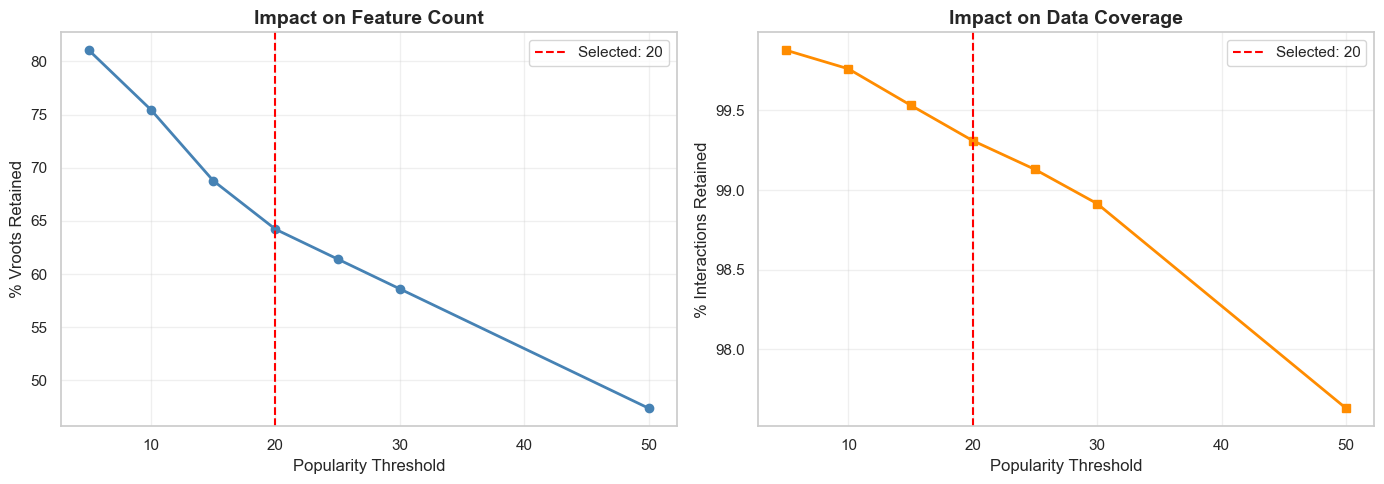


Selected Threshold: 20
Items retained: 183 (64.2%)
while filtering 35.8% of noisy features


In [24]:
# ==========================================================
# 4. FEATURE SELECTION: POPULARITY THRESHOLD
# ==========================================================
print("\nStep 4: Conduct feature selection via popularity threshold")

thresholds = [5, 10, 15, 20, 25, 30, 50]
threshold_analysis = []

for thresh in thresholds:
  selected = item_popularity[item_popularity >= thresh]
  retained_interactions = df_train[df_train['vroot_id'].isin(selected.index)]

  threshold_analysis.append({
      'threshold': thresh,
      'vroots_retained': len(selected),
      'vroots_percentage': (len(selected) / len(item_popularity)) * 100,
      'interactions_percentage': len(retained_interactions) / len(df_train) * 100,
      'avg_popularity': selected.mean()
  })

threshold_df = pd.DataFrame(threshold_analysis)
print("\n", threshold_df.to_string(index=False))

# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(threshold_df['threshold'], threshold_df['vroots_percentage'],
             marker='o', color='steelblue', linewidth=2)
axes[0].set_xlabel('Popularity Threshold', fontsize=12)
axes[0].set_ylabel('% Vroots Retained', fontsize=12)
axes[0].set_title('Impact on Feature Count', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=20, color='red', linestyle='--', label='Selected: 20')
axes[0].legend()

axes[1].plot(threshold_df['threshold'], threshold_df['interactions_percentage'],
             marker='s', color='darkorange', linewidth=2)
axes[1].set_xlabel('Popularity Threshold', fontsize=12)
axes[1].set_ylabel('% Interactions Retained', fontsize=12)
axes[1].set_title('Impact on Data Coverage', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=20, color='red', linestyle='--', label='Selected: 20')
axes[1].legend()

plt.tight_layout()
plt.show()

# Select optimal threshold: 20 (balances noise reduction and data retention)
SELECTED_THRESHOLD = 20
selected_vroots = item_popularity[item_popularity >= SELECTED_THRESHOLD].index
print(f"\nSelected Threshold: {SELECTED_THRESHOLD}")
print(f"Items retained: {len(selected_vroots)} ({len(selected_vroots)/len(item_popularity)*100:.1f}%)")
print(f"while filtering {100-threshold_df[threshold_df['threshold']==SELECTED_THRESHOLD]['vroots_percentage'].values[0]:.1f}% of noisy features")

user_item_filtered = user_item_matrix[selected_vroots]

## 3.4. Application of TF-IDF Transformation

In [25]:
# ==========================================================
# 5. FEATURE TRANSFORMATION: TF-IDF
# ==========================================================
# Compare raw vs TF-IDF
print("\nStep 5 TF-IDF Transformation")
print("  - Raw binary features treat all vroots equally")
print("  - TF-IDF upweights rare vroots (indicating specific interests)")
print("  - TF-IDF downweights common vroots (e.g., homepage, search)")

tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(user_item_filtered)
df_train_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=user_item_filtered.index,
    columns=user_item_filtered.columns
)

# Show sample
sample_user = df_train_tfidf.index[0]
print(f"\n  Example User {sample_user}:")
print(f"  Raw visits {user_item_filtered.loc[sample_user].sum():.0f} items")
print(f"  TF-IDF range: [{df_train_tfidf.loc[sample_user].min():.3f}, {df_train_tfidf.loc[sample_user].max():.3f}]")


Step 5 TF-IDF Transformation
  - Raw binary features treat all vroots equally
  - TF-IDF upweights rare vroots (indicating specific interests)
  - TF-IDF downweights common vroots (e.g., homepage, search)

  Example User 10001:
  Raw visits 3 items
  TF-IDF range: [0.000, 0.658]


## 3.5. Evaluation of Feature Quality


Step 6 Feature Importance Analysis

[Method 1] Variance-Based Importance

  Top 10 Highest Variance Features (Most Discriminative):
    1. Internet Explorer: 0.0861
    2. Microsoft.com Search: 0.0788
    3. Free Downloads: 0.0603
    4. Windows Family of OSs: 0.0342
    5. Support Desktop: 0.0288
    6. Web Site Builder's Gallery: 0.0287
    7. Products : 0.0270
    8. Internet Site Construction for Developers: 0.0251
    9. isapi: 0.0238
    10. Games: 0.0206

[Method 2] Item-Item Correlation (Cosine Similarity)

  Most Correlated Vroot Pair:
    MS Project <-> MS Project
    Similarity: 0.476


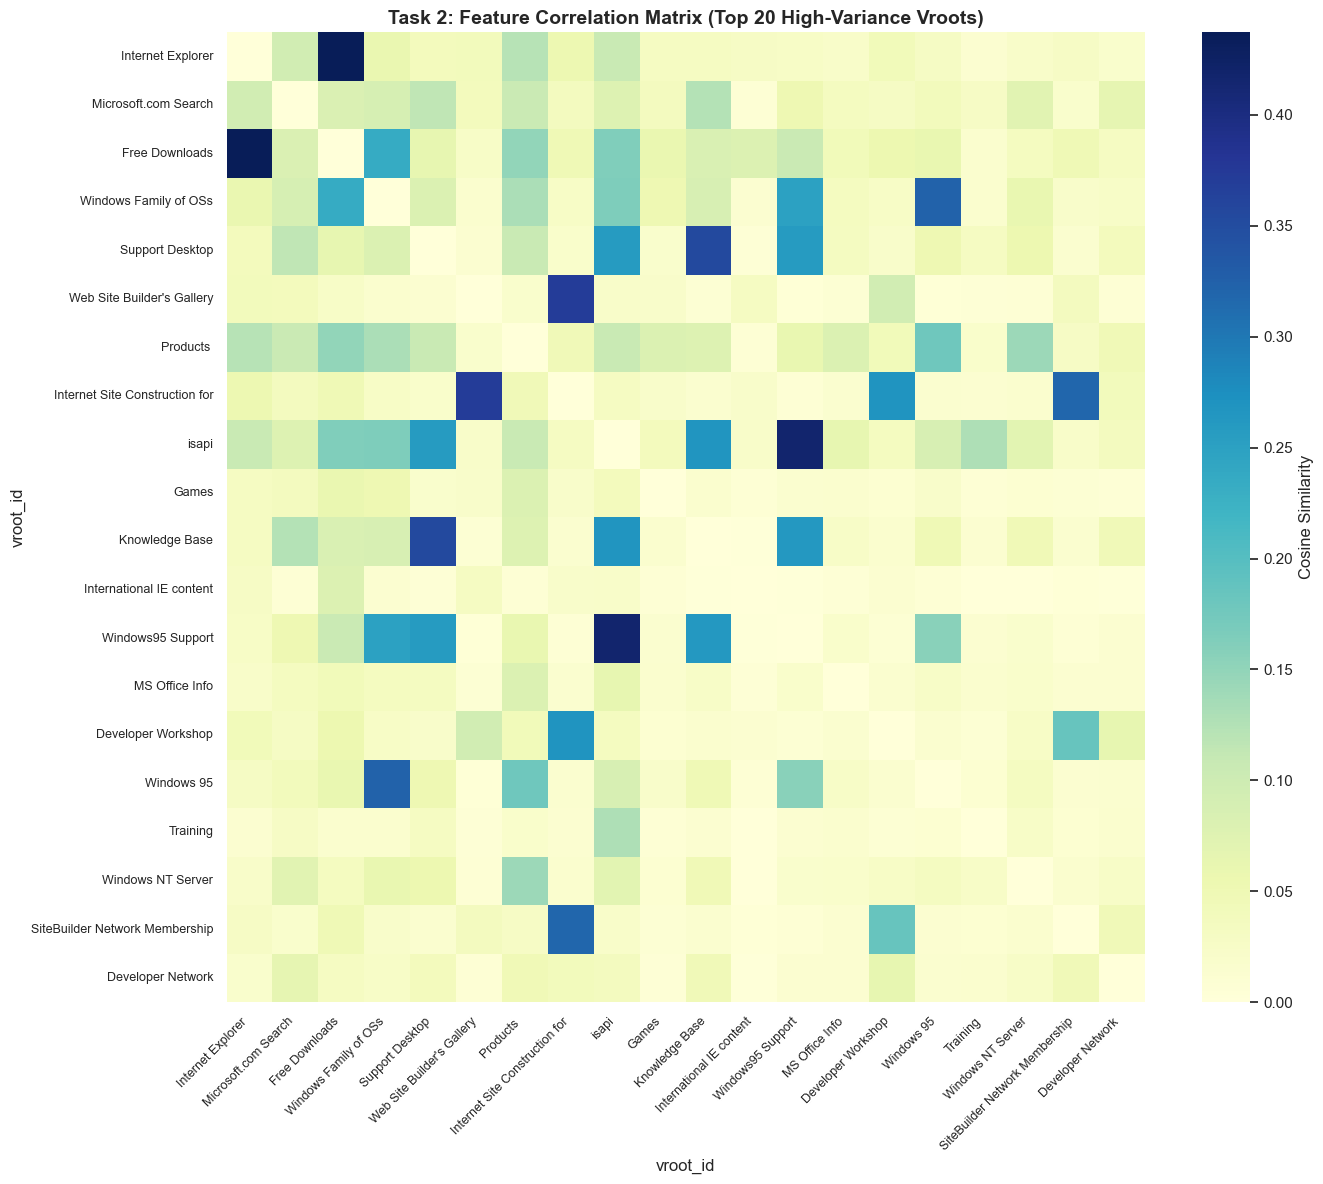

In [26]:
# ==========================================================
# 6. FEATURE IMPORTANCE ANALYSIS
# ==========================================================

print("\nStep 6 Feature Importance Analysis")

# 6A. Variance Analysis
print("\n[Method 1] Variance-Based Importance")
feature_variance = df_train_tfidf.var().sort_values(ascending=False)
print(f"\n  Top 10 Highest Variance Features (Most Discriminative):")
for i, (vid, var) in enumerate(feature_variance.head(10).items(), 1):
    title = df_attr[df_attr['vroot_id']==vid]['title'].values[0] if vid in df_attr['vroot_id'].values else "Unknown"
    print(f"    {i}. {title[:50]}: {var:.4f}")

# 6B. Correlation Analysis (Item-Item)
print("\n[Method 2] Item-Item Correlation (Cosine Similarity)")
item_similarity = cosine_similarity(df_train_tfidf.T)
item_sim_df = pd.DataFrame(item_similarity, index=selected_vroots, columns=selected_vroots)

# Find most correlated pairs
np.fill_diagonal(item_similarity, 0)  # Exclude self-similarity
max_sim_idx = np.unravel_index(item_similarity.argmax(), item_similarity.shape)
item1, item2 = selected_vroots[max_sim_idx[0]], selected_vroots[max_sim_idx[1]]
title1 = df_attr[df_attr['vroot_id']==item1]['title'].values[0]
title2 = df_attr[df_attr['vroot_id']==item2]['title'].values[0]

print(f"\n  Most Correlated Vroot Pair:")
print(f"    {title1} <-> {title2}")
print(f"    Similarity: {item_similarity[max_sim_idx]:.3f}")

# Heatmap for top 20
top_20_ids = feature_variance.head(20).index
top_20_names = [df_attr[df_attr['vroot_id']==vid]['title'].values[0][:30]
                for vid in top_20_ids]

plt.figure(figsize=(14, 12))
sns.heatmap(item_sim_df.loc[top_20_ids, top_20_ids],
            cmap='YlGnBu',
            xticklabels=top_20_names,
            yticklabels=top_20_names,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Task 2: Feature Correlation Matrix (Top 20 High-Variance Vroots)',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


[Method 3] PCA for Dimensionality Reduction
Original Dimenions: 183
Components for 95% variance: 168
Dimentionality reduction: 8.20%


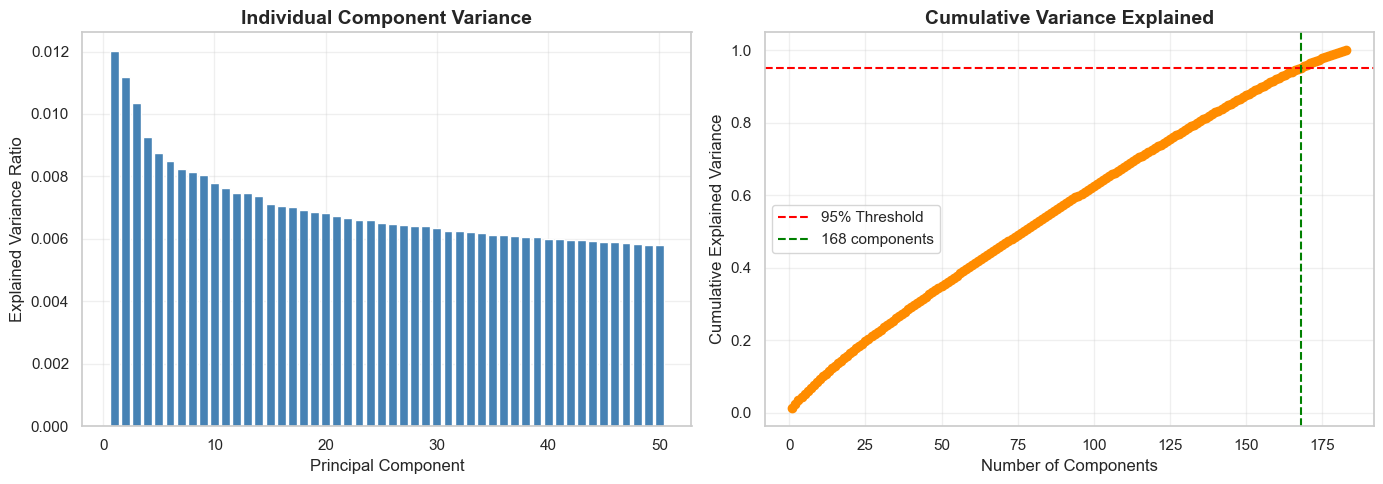

In [27]:
# 6C. PCA (Dimensionality Reduction Analysis)
print("\n[Method 3] PCA for Dimensionality Reduction")
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_train_tfidf)

# Apply PCA
pca = PCA()
pca.fit(scaled_features)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
n_components_95 = np.argmax(cumulative_var >= 0.95) + 1

print(f"Original Dimenions: {df_train_tfidf.shape[1]}")
print(f"Components for 95% variance: {n_components_95}")
print(f"Dimentionality reduction: {(1 - n_components_95 / df_train_tfidf.shape[1]) * 100:.2f}%")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, min(51, len(explained_var)+1)), explained_var[:50], color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Individual Component Variance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', color='darkorange')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
axes[1].axvline(x=n_components_95, color='green', linestyle='--', label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# ==========================================================
# 7. SAVE FEATURES
# ==========================================================
print("\n Step 6")
user_item_filtered.to_csv('train_binary_matrix.csv', index=True)
print("train_binary_matrix.csv saved successfully!")

item_popularity.to_csv('item_popularity.csv', index=True)
print("item_popularity.csv saved successfully!")

item_sim_df.to_csv('item_similarity_matrix.csv', index=True)
print("item_similarity_matrix.csv saved successfully!")

df_train_tfidf.to_csv('train_tfidf_features.csv', index=True)
print("train_tfidf_features.csv saved successfully!")


 Step 6
train_binary_matrix.csv saved successfully!
item_popularity.csv saved successfully!
item_similarity_matrix.csv saved successfully!
train_tfidf_features.csv saved successfully!


# 3. Data Modeling

Evaluation method

In [29]:
def calculate_metrics_at_k(recommendations, ground_truth, k=5):
    """
    Calculate Precision@K, Recall@K, Hit Rate@K for all users.
    """
    precisions = []
    recalls = []
    hits = []
    for user_id, rec_items in recommendations.items():
        if user_id not in ground_truth:
            continue

        true_items = set(ground_truth[user_id])
        rec_items_k = rec_items[:k]

        if len(true_items) == 0:
            continue

        # Precision@K
        relevant_and_recommended = len(set(rec_items_k) & true_items)
        precision = relevant_and_recommended / k if k > 0 else 0
        precisions.append(precision)

        # Recall@K
        recall = relevant_and_recommended / len(true_items) if len(true_items) > 0 else 0
        recalls.append(recall)

        # Hit Rate@K
        hit = 1 if relevant_and_recommended > 0 else 0
        hits.append(hit)

    return {
        'Precision@5': np.mean(precisions),
        'Recall@5': np.mean(recalls),
        'Hit_Rate@5': np.mean(hits)
    }

def calculate_catalog_coverage(recommendations, total_items):
    """Calculate percentage of catalog covered by recommendations."""
    all_recommended = set()
    for recs in recommendations.values():
        all_recommended.update(recs)
    return len(all_recommended) / total_items * 100

def calculate_personalization(recommendations):
    """Calculate diversity of recommendations (1 - similarity)."""
    from itertools import combinations
    users = list(recommendations.keys())
    if len(users) < 2:
        return 0

    # Sample 1000 user pairs for efficiency
    n_pairs = min(1000, len(list(combinations(users, 2))))
    sampled_users = np.random.choice(users, min(100, len(users)), replace=False)

    similarities = []
    for u1, u2 in combinations(sampled_users, 2):
        set1 = set(recommendations[u1])
        set2 = set(recommendations[u2])
        if len(set1) == 0 or len(set2) == 0:
            continue
        jaccard = len(set1 & set2) / len(set1 | set2)
        similarities.append(jaccard)

    return 1 - np.mean(similarities) if similarities else 0

In [30]:
def analyze_by_user_activity(recommendations, ground_truth, train_binary):
    """
    Analyze performance by user activity level.
    """
    # Categorize users
    low_activity = []  # 3-5 interactions
    medium_activity = []  # 6-10 interactions
    high_activity = []  # 11+ interactions

    for user_id in recommendations.keys():
        if user_id not in ground_truth:
            continue

        # Get user's training history
        if user_id in train_binary.index:
            n_interactions = train_binary.loc[user_id].sum()
        else:
            n_interactions = 0

        true_items = set(ground_truth[user_id])
        rec_items = recommendations[user_id][:5]
        relevant = len(set(rec_items) & true_items)
        precision = relevant / 5

        if n_interactions <= 5:
            low_activity.append(precision)
        elif n_interactions <= 10:
            medium_activity.append(precision)
        else:
            high_activity.append(precision)

    return {
        'Low Activity (1-5)': {
            'count': len(low_activity),
            'precision': np.mean(low_activity) if low_activity else 0
        },
        'Medium Activity (6-10)': {
            'count': len(medium_activity),
            'precision': np.mean(medium_activity) if medium_activity else 0
        },
        'High Activity (11+)': {
            'count': len(high_activity),
            'precision': np.mean(high_activity) if high_activity else 0
        }
    }

## 3.1 Content-based models

In [ ]:
# All necessary imports for content-based recommendation models

# Core libraries
import numpy as np
import pandas as pd
from typing import Dict, List, Set, Tuple, Optional

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from 

### Data Splitting Strategies

For robust model evaluation, we implement two complementary splitting strategies:

**Leave-One-Out Split**
- **Purpose**: Fast validation during hyperparameter tuning
- **Method**: Holds out the last interaction per user for validation
- **Advantage**: Maximizes training data while ensuring all users have validation samples
- **Use case**: Quick model comparison and tuning

**K-Fold Cross-Validation**
- **Purpose**: Comprehensive evaluation with reduced variance
- **Method**: Splits users into K folds, rotating validation sets
- **Advantage**: More robust performance estimates with confidence intervals
- **Use case**: Final model selection and performance reporting

In [32]:
def leave_one_out_split(df, user_col='user_id', item_col='vroot_id', min_interactions=2):
    """
    Performs a leave-one-out split for recommendation system evaluation.

    Args:
        df (pd.DataFrame): Input dataframe containing user-item interactions
        user_col (str): Name of the user ID column
        item_col (str): Name of the item ID column
        min_interactions (int): Minimum number of interactions a user must have to be included in validation

    Returns:
        tuple: (train_pivot, val_ground_truth, df_train_split, df_val)
            - train_pivot (pd.DataFrame): Binary user-item matrix for training
            - val_ground_truth (dict): Dictionary mapping user IDs to list of validation items
            - df_train_split (pd.DataFrame): Training dataframe (without validation items)
            - df_val (pd.DataFrame): Validation dataframe (one item per user)
    """
    # Ensure IDs are strings
    df = df.copy()
    df[user_col] = df[user_col].astype(str)
    df[item_col] = df[item_col].astype(str)

    # Identify users with at least min_interactions for Leave-One-Out split
    user_counts = df.groupby(user_col).size()
    valid_val_users = user_counts[user_counts >= min_interactions].index

    # Create Validation split (last interaction per user)
    df_val = df[df[user_col].isin(valid_val_users)].groupby(user_col).tail(1)
    df_train_split = df.drop(df_val.index)

    # Create Training Pivot (binary user-item matrix)
    train_pivot = df_train_split.pivot_table(
        index=user_col,
        columns=item_col,
        aggfunc='size',
        fill_value=0
    )
    train_pivot = (train_pivot > 0).astype(np.float32)

    # Create Validation Ground Truth
    val_ground_truth = df_val.groupby(user_col)[item_col].apply(list).to_dict()

    print(f"Split complete: {len(train_pivot)} users in training, {len(val_ground_truth)} users for validation.")
    print(f"Sample validation users: {list(val_ground_truth.items())[:3]}")

    return train_pivot, val_ground_truth, df_train_split, df_val

# Perform leave-one-out split
# Use min_interactions=2 to ensure we have users from various activity levels
# This allows for better stratification across Low/Medium/High activity categories
train_tuning_pivot, val_ground_truth, df_train_split, df_val = leave_one_out_split(
    df_train,
    user_col='user_id',
    item_col='vroot_id',
    min_interactions=2
)

print(f"\nTraining set shape: {train_tuning_pivot.shape}")
print(f"Validation users: {len(val_ground_truth)}")
print(f"Training interactions: {len(df_train_split)}")
print(f"Validation interactions: {len(df_val)}")

# Check activity level distribution in validation set
print("\n" + "="*60)
print("Validation Set Activity Distribution:")
print("="*60)
user_activity_counts = df_train.groupby('user_id').size()
val_user_ids = list(val_ground_truth.keys())
val_activities = [user_activity_counts.get(uid, 0) for uid in val_user_ids]
low_count = sum(1 for a in val_activities if a <= 5)
med_count = sum(1 for a in val_activities if 6 <= a <= 10)
high_count = sum(1 for a in val_activities if a > 10)
print(f"Low Activity (1-5):     {low_count:4d} users ({low_count/len(val_user_ids)*100:5.1f}%)")
print(f"Medium Activity (6-10): {med_count:4d} users ({med_count/len(val_user_ids)*100:5.1f}%)")
print(f"High Activity (11+):    {high_count:4d} users ({high_count/len(val_user_ids)*100:5.1f}%)")
print("="*60)

Split complete: 32711 users in training, 22716 users for validation.
Sample validation users: [('10001', ['1002']), ('10002', ['1003']), ('10003', ['1004'])]

Training set shape: (32711, 279)
Validation users: 22716
Training interactions: 75938
Validation interactions: 22716

Validation Set Activity Distribution:
Low Activity (1-5):     22716 users (100.0%)
Medium Activity (6-10):    0 users (  0.0%)
High Activity (11+):       0 users (  0.0%)


In [33]:
def kfold_split_temporal(df, user_col='user_id', item_col='vroot_id', n_splits=5, min_interactions=2):
    """
    Performs K-Fold cross-validation split with temporal ordering for recommendation systems.
    
    Args:
        df (pd.DataFrame): Input dataframe containing user-item interactions
        user_col (str): Name of the user ID column
        item_col (str): Name of the item ID column
        n_splits (int): Number of folds for cross-validation
        min_interactions (int): Minimum interactions required per user to be included
    
    Returns:
        list: List of tuples (train_data, val_data, val_ground_truth) for each fold
    """
    # Ensure IDs are strings
    df = df.copy()
    df[user_col] = df[user_col].astype(str)
    df[item_col] = df[item_col].astype(str)
    
    # Filter users with sufficient interactions
    user_counts = df.groupby(user_col).size()
    valid_users = user_counts[user_counts >= min_interactions].index
    df_filtered = df[df[user_col].isin(valid_users)]
    
    print(f"Total users before filtering: {df[user_col].nunique()}")
    print(f"Users with >= {min_interactions} interactions: {len(valid_users)}")
    
    folds = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(valid_users)):
        # Split users into train and validation
        train_users = valid_users[train_idx]
        val_users = valid_users[val_idx]
        
        # For each validation user, take last interaction as validation
        val_data = df_filtered[df_filtered[user_col].isin(val_users)].groupby(user_col).tail(1)
        train_data = df_filtered.drop(val_data.index)
        
        # Add all train user interactions to training set
        train_full = pd.concat([
            train_data,
            df_filtered[df_filtered[user_col].isin(train_users)]
        ]).drop_duplicates()
        
        # Create validation ground truth
        val_ground_truth = val_data.groupby(user_col)[item_col].apply(list).to_dict()
        
        folds.append((train_full, val_data, val_ground_truth))
        
        print(f"\nFold {fold_idx + 1}:")
        print(f"  Train users: {train_full[user_col].nunique()}")
        print(f"  Val users: {len(val_ground_truth)}")
        print(f"  Train interactions: {len(train_full)}")
        print(f"  Val interactions: {len(val_data)}")
    
    return folds

# Create K-Fold splits
print("="*80)
print("CREATING K-FOLD CROSS-VALIDATION SPLITS")
print("="*80)

kfold_splits = kfold_split_temporal(
    df_train,
    user_col='user_id',
    item_col='vroot_id',
    n_splits=5,
    min_interactions=2
)

print("\n" + "="*80)
print(f"K-Fold setup complete: {len(kfold_splits)} folds created")
print("="*80)

CREATING K-FOLD CROSS-VALIDATION SPLITS
Total users before filtering: 32711
Users with >= 2 interactions: 22716

Fold 1:
  Train users: 22716
  Val users: 4544
  Train interactions: 84115
  Val interactions: 4544

Fold 2:
  Train users: 22716
  Val users: 4543
  Train interactions: 84116
  Val interactions: 4543

Fold 3:
  Train users: 22716
  Val users: 4543
  Train interactions: 84116
  Val interactions: 4543

Fold 4:
  Train users: 22716
  Val users: 4543
  Train interactions: 84116
  Val interactions: 4543

Fold 5:
  Train users: 22716
  Val users: 4543
  Train interactions: 84116
  Val interactions: 4543

K-Fold setup complete: 5 folds created


### Base Model Classes

In [34]:
class ContentModel:
    """Base class to handle user history and common logic."""

    def __init__(self, train_df: pd.DataFrame, attr_df: pd.DataFrame,
                 id_map: Dict, idx_map: Dict):
        self.train_df = train_df
        self.attr_df = attr_df
        # Pre-compute user histories for fast lookup
        self.user_histories = train_df.groupby(
            'user_id')['vroot_id'].apply(set).to_dict()
        self.id_to_idx = id_map
        self.idx_to_id = idx_map

    def get_user_history(self, user_id: int) -> Set:
        """Get the set of items a user has interacted with."""
        return self.user_histories.get(user_id, set())

    def _filter_recs(self, candidates: np.ndarray, history: Set, k: int) -> List:
        """Filters out items already seen by the user."""
        recs = []
        for idx in candidates:
            v_id = self.idx_to_id[idx]
            if v_id not in history:
                recs.append(v_id)
                if len(recs) >= k:
                    break
        return recs

    def _format_results(self, recommendations: List, k: int) -> List:
        """Format recommendations to return item IDs."""
        return recommendations[:k]

In [35]:
class CosineRecommender(ContentModel):
    """Content-based recommender using Cosine Similarity on TF-IDF vectors."""

    def __init__(self, tfidf_matrix, train_data: pd.DataFrame,
                 attr_data: pd.DataFrame, id_map: Dict, idx_map: Dict):
        super().__init__(train_data, attr_data, id_map, idx_map)
        # Pre-compute similarity matrix (efficient for smaller datasets)
        self.sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
        print(tfidf_matrix.shape)

    def recommend(self, user_id: int, k: int = 5) -> List:
        """Generate top-k recommendations for a user."""
        user_history = self.get_user_history(user_id)
        if not user_history:
            return []

        # Aggregate similarity scores for all items the user hasn't seen
        total_scores = np.zeros(self.sim_matrix.shape[0])

        for item_id in user_history:
            if item_id in self.id_to_idx:
                idx = self.id_to_idx[item_id]
                total_scores += self.sim_matrix[idx]

        # Sort indices by score (descending)
        top_indices = total_scores.argsort()[::-1]

        # Filter out items already visited
        return self._filter_recs(top_indices, user_history, k)

In [36]:
class KNNRecommender(ContentModel):
    """Content-based recommender using K-Nearest Neighbors."""

    def __init__(self, tfidf_matrix, train_df: pd.DataFrame,
                 attr_df: pd.DataFrame, id_map: Dict, idx_map: Dict,
                 k_neighbors: int = 10):
        super().__init__(train_df, attr_df, id_map, idx_map)
        self.k_neighbors = k_neighbors
        self.tfidf_matrix = tfidf_matrix
        # Model: Find items similar to the user's profile
        self.model = NearestNeighbors(
            metric='cosine',
            algorithm='brute',
            n_neighbors=k_neighbors
        )
        self.model.fit(tfidf_matrix)

    def recommend(self, user_id: int, k: int = 5) -> List:
        """Generate top-k recommendations for a user."""
        history = self.get_user_history(user_id)
        if not history:
            return []

        # 1. Build User Profile (Average of TF-IDF vectors of visited items)
        indices = [self.id_to_idx[i] for i in history if i in self.id_to_idx]
        if not indices:
            return []

        user_profile = np.asarray(self.tfidf_matrix[indices].mean(axis=0))

        # 2. Find Neighbors
        # Fetch more neighbors than k to account for filtering seen items
        n_query = min(self.k_neighbors + len(history),
                      self.tfidf_matrix.shape[0])
        _, neighbor_indices = self.model.kneighbors(
            user_profile, n_neighbors=n_query)

        return self._filter_recs(neighbor_indices.flatten(), history, k)

In [37]:
class SVDRecommender(ContentModel):
    """Content-based recommender using SVD/LSA for dimensionality reduction."""

    def __init__(self, tfidf_matrix, train_df: pd.DataFrame,
                 attr_df: pd.DataFrame, id_map: Dict, idx_map: Dict,
                 n_components: int = 50):
        super().__init__(train_df, attr_df, id_map, idx_map)
        # Dimensionality Reduction (LSA)
        n_comps = min(n_components, tfidf_matrix.shape[1] - 1)
        self.svd = TruncatedSVD(n_components=n_comps, random_state=42)
        matrix_reduced = self.svd.fit_transform(tfidf_matrix)

        # Compute Similarity on Reduced Matrix
        self.sim_matrix = cosine_similarity(matrix_reduced)

    def recommend(self, user_id: int, k: int = 5) -> List:
        """Generate top-k recommendations for a user."""
        history = self.get_user_history(user_id)
        if not history:
            return []

        # Aggregate similarity scores
        total_scores = np.zeros(self.sim_matrix.shape[0])
        for item_id in history:
            if item_id in self.id_to_idx:
                idx = self.id_to_idx[item_id]
                total_scores += self.sim_matrix[idx]

        # Sort by score
        top_indices = total_scores.argsort()[::-1]

        return self._filter_recs(top_indices, history, k)

In [38]:
class TFIDFTuner:
    """
    Tunes TF-IDF vectorizer parameters and model hyperparameters.
    Tests different n-gram ranges (unigram, bigram, trigram).
    """

    def __init__(self, attr_df: pd.DataFrame, train_df: pd.DataFrame,
                 val_df: pd.DataFrame = None, val_ground_truth: Dict = None,
                 text_column: str = 'title'):
        self.attr_df = attr_df
        self.train_df = train_df
        self.val_df = val_df
        self.val_ground_truth = val_ground_truth
        self.text_column = text_column
        self.results = []

    def create_id_mappings(self, attr_df: pd.DataFrame) -> Tuple[Dict, Dict]:
        """Create bidirectional mappings between item IDs and indices."""
        # Ensure item IDs are strings to match validation ground truth format
        item_ids = attr_df['vroot_id'].astype(str).values
        id_to_idx = {v_id: i for i, v_id in enumerate(item_ids)}
        idx_to_id = {i: v_id for i, v_id in enumerate(item_ids)}
        return id_to_idx, idx_to_id

    def create_tfidf_matrix(self, ngram_range: Tuple[int, int],
                            max_features: Optional[int] = None,
                            min_df: int = 1,
                            max_df: float = 1.0):
        """
        Create TF-IDF matrix with specified parameters.

        Args:
            ngram_range: Tuple (min_n, max_n) for n-gram range
                        (1, 1) = unigram, (1, 2) = unigram+bigram, (1, 3) = unigram+bigram+trigram
                        (2, 2) = bigram only, (3, 3) = trigram only
            max_features: Maximum number of features
            min_df: Minimum document frequency
            max_df: Maximum document frequency (as fraction)
        """
        tfidf = TfidfVectorizer(
            stop_words='english',
            ngram_range=ngram_range,
            max_features=max_features,
            min_df=min_df,
            max_df=max_df
        )
        tfidf_matrix = tfidf.fit_transform(self.attr_df[self.text_column])
        return tfidf_matrix, tfidf

    def evaluate_model(self, model, val_users: List = None, val_ground_truth: Dict = None, k: int = 5) -> float:
        """
        Evaluates the average of Precision, Recall, and Hit Rate on validation set.
        
        Args:
            model: Trained recommendation model
            val_users: List of validation user IDs (if None, uses self.val_ground_truth)
            val_ground_truth: Dict mapping user_id to validation items (if None, uses self.val_ground_truth)
            k: Number of recommendations
            
        Returns:
            float: Average of Precision@K, Recall@K, and Hit Rate@K
        """
        # Use provided validation data or class attributes
        if val_ground_truth is None:
            val_ground_truth = self.val_ground_truth
        if val_users is None:
            val_users = list(val_ground_truth.keys())
            
        if val_ground_truth is None:
            raise ValueError("No validation ground truth provided")
            
        precisions = []
        recalls = []
        hits = []

        for user_id in val_users:
            # Check if we have training history for this user
            if not model.get_user_history(user_id):
                continue

            # Ground Truth (Items in validation set)
            truth = set(val_ground_truth[user_id]) if isinstance(val_ground_truth[user_id], list) else {val_ground_truth[user_id]}

            # Prediction
            recs = model.recommend(user_id, k=k)
            recs_set = set(recs)

            # Calculate metrics
            relevant_and_recommended = len(recs_set & truth)
            
            # Precision@K
            precision = relevant_and_recommended / k if k > 0 else 0
            precisions.append(precision)
            
            # Recall@K
            recall = relevant_and_recommended / len(truth) if len(truth) > 0 else 0
            recalls.append(recall)
            
            # Hit Rate@K
            hit = 1 if relevant_and_recommended > 0 else 0
            hits.append(hit)

        # Calculate average metrics
        avg_precision = np.mean(precisions) if precisions else 0
        avg_recall = np.mean(recalls) if recalls else 0
        avg_hit_rate = np.mean(hits) if hits else 0
        
        # Return average of all three metrics
        return (avg_precision + avg_recall + avg_hit_rate) / 3

    def tune_all_models(self,
                        ngram_configs: Optional[List[Tuple[int, int]]] = None,
                        knn_neighbors: Optional[List[int]] = None,
                        svd_components: Optional[List[int]] = None,
                        k: int = 5) -> pd.DataFrame:
        """
        Comprehensive tuning across all models and n-gram configurations.
        Uses the validation split provided during initialization.

        Args:
            ngram_configs: List of n-gram ranges to test
            knn_neighbors: List of k values for KNN
            svd_components: List of component values for SVD
            k: Number of recommendations for evaluation

        Returns:
            DataFrame with all results
        """
        # Validate that validation data is available
        if self.val_ground_truth is None:
            raise ValueError("No validation data provided. Please provide val_df and val_ground_truth during initialization.")
        
        # Default configurations
        if ngram_configs is None:
            ngram_configs = [
                (1, 1),  # Unigram only
                (2, 2),  # Bigram only
                (3, 3),  # Trigram only
                (1, 2),  # Unigram + Bigram
                (1, 3),  # Unigram + Bigram + Trigram
            ]

        if knn_neighbors is None:
            knn_neighbors = [5, 10, 20, 50]

        if svd_components is None:
            svd_components = [10, 20, 50, 100]

        val_users = list(self.val_ground_truth.keys())

        print(f"\n{'='*60}")
        print(f"STARTING COMPREHENSIVE HYPERPARAMETER TUNING")
        print(f"{'='*60}")
        print(f"Training samples: {len(self.train_df)}")
        print(f"Validation users: {len(val_users)}")
        print(f"N-gram configurations: {len(ngram_configs)}")
        print(
            f"Total configurations to test: {len(ngram_configs) * (1 + len(knn_neighbors) + len(svd_components))}")
        print(f"Evaluation Metric: Average of Precision@5, Recall@5, and Hit Rate@5")
        print(f"{'='*60}\n")

        for ngram_range in ngram_configs:
            ngram_name = self._get_ngram_name(ngram_range)
            print(f"\n--- Testing {ngram_name} ---")

            # Create TF-IDF matrix for this n-gram configuration
            tfidf_matrix, tfidf_vectorizer = self.create_tfidf_matrix(
                ngram_range)
            id_to_idx, idx_to_id = self.create_id_mappings(self.attr_df)

            print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

            # Test Cosine Similarity
            print(f"  Testing Cosine Similarity...", end=" ")
            model = CosineRecommender(
                tfidf_matrix, self.train_df, self.attr_df,
                id_to_idx, idx_to_id
            )
            score = self.evaluate_model(model, val_users, self.val_ground_truth, k=k)
            self.results.append({
                'Model': 'Cosine',
                'N-gram': ngram_name,
                'N-gram_Range': str(ngram_range),
                'Param': 'N/A',
                'AvgScore@5': score,
                'Matrix_Shape': str(tfidf_matrix.shape)
            })
            print(f"Avg Score: {score:.4f}")

            # Test KNN
            for k_n in knn_neighbors:
                print(f"  Testing KNN (k={k_n})...", end=" ")
                model = KNNRecommender(
                    tfidf_matrix, self.train_df, self.attr_df,
                    id_to_idx, idx_to_id, k_neighbors=k_n
                )
                score = self.evaluate_model(model, val_users, self.val_ground_truth, k=k)
                self.results.append({
                    'Model': 'KNN',
                    'N-gram': ngram_name,
                    'N-gram_Range': str(ngram_range),
                    'Param': f'k={k_n}',
                    'AvgScore@5': score,
                    'Matrix_Shape': str(tfidf_matrix.shape)
                })
                print(f"Avg Score: {score:.4f}")

            # Test SVD
            for n_c in svd_components:
                # Skip if n_components >= n_features
                if n_c >= tfidf_matrix.shape[1]:
                    print(
                        f"  Skipping SVD (components={n_c}, too large for matrix)")
                    continue

                print(f"  Testing SVD (components={n_c})...", end=" ")
                model = SVDRecommender(
                    tfidf_matrix, self.train_df, self.attr_df,
                    id_to_idx, idx_to_id, n_components=n_c
                )
                score = self.evaluate_model(model, val_users, self.val_ground_truth, k=k)
                self.results.append({
                    'Model': 'SVD',
                    'N-gram': ngram_name,
                    'N-gram_Range': str(ngram_range),
                    'Param': f'comp={n_c}',
                    'AvgScore@5': score,
                    'Matrix_Shape': str(tfidf_matrix.shape)
                })
                print(f"Avg Score: {score:.4f}")

        # Create results dataframe
        df_results = pd.DataFrame(self.results).sort_values(
            by='AvgScore@5', ascending=False
        )

        print(f"\n{'='*60}")
        print(f"TUNING RESULTS (Top 10)")
        print(f"{'='*60}")
        print(df_results.head(10).to_string(index=False))

        # Print best configuration
        best = df_results.iloc[0]
        print(f"\n{'='*60}")
        print(f"BEST CONFIGURATION")
        print(f"{'='*60}")
        print(f"Model: {best['Model']}")
        print(f"N-gram: {best['N-gram']}")
        print(f"Parameter: {best['Param']}")
        print(f"Average Score@5 (Precision + Recall + HitRate)/3: {best['AvgScore@5']:.4f}")
        print(f"{'='*60}\n")

        return df_results

    def _get_ngram_name(self, ngram_range: Tuple[int, int]) -> str:
        """Convert n-gram range tuple to readable name."""
        if ngram_range == (1, 1):
            return "Unigram"
        elif ngram_range == (2, 2):
            return "Bigram"
        elif ngram_range == (3, 3):
            return "Trigram"
        elif ngram_range == (1, 2):
            return "Uni+Bigram"
        elif ngram_range == (1, 3):
            return "Uni+Bi+Trigram"
        elif ngram_range == (2, 3):
            return "Bi+Trigram"
        else:
            return f"{ngram_range[0]}-{ngram_range[1]}gram"

    def get_best_config(self) -> Dict:
        """Return the best configuration from tuning results."""
        if not self.results:
            raise ValueError(
                "No tuning results available. Run tune_all_models first.")

        df_results = pd.DataFrame(self.results).sort_values(
            by='AvgScore@5', ascending=False
        )
        best = df_results.iloc[0]

        return {
            'model': best['Model'],
            'ngram': best['N-gram'],
            'ngram_range': eval(best['N-gram_Range']),
            'param': best['Param'],
            'avg_score': best['AvgScore@5']
        }

    def train_best_model(self):
        """Train and return the best model on full training data."""
        best_config = self.get_best_config()

        # Create TF-IDF matrix with best n-gram configuration
        tfidf_matrix, _ = self.create_tfidf_matrix(best_config['ngram_range'])
        id_to_idx, idx_to_id = self.create_id_mappings(self.attr_df)

        model_type = best_config['model']

        if model_type == 'Cosine':
            model = CosineRecommender(
                tfidf_matrix, self.train_df, self.attr_df,
                id_to_idx, idx_to_id
            )
        elif model_type == 'KNN':
            k_n = int(best_config['param'].split('=')[1])
            model = KNNRecommender(
                tfidf_matrix, self.train_df, self.attr_df,
                id_to_idx, idx_to_id, k_neighbors=k_n
            )
        elif model_type == 'SVD':
            n_c = int(best_config['param'].split('=')[1])
            model = SVDRecommender(
                tfidf_matrix, self.train_df, self.attr_df,
                id_to_idx, idx_to_id, n_components=n_c
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")

        print(
            f"\nTrained best model: {model_type} with {best_config['ngram']} ({best_config['param']})")
        return model, tfidf_matrix, id_to_idx, idx_to_id


### Hyperparameter Tuning

The `TFIDFTuner` class provides comprehensive hyperparameter search across:

**N-gram Configurations:**
- **Unigram (1,1)**: Individual words - captures specific terms
- **Bigram (2,2)**: Two-word phrases - captures common phrases
- **Trigram (3,3)**: Three-word phrases - captures longer expressions
- **Uni+Bigram (1,2)**: Combined features - balances specificity and context
- **Uni+Bi+Trigram (1,3)**: Maximum features - highest dimensionality

**Model Hyperparameters:**
- **Cosine**: No hyperparameters (baseline)
- **KNN**: k_neighbors ∈ [5, 10, 20, 50]
- **SVD**: n_components ∈ [10, 20, 50, 100]

**Evaluation:**
- Uses leave-one-out validation split
- Measures the average of Precision@5, Recall@5, and Hit Rate@5 for balanced performance evaluation
- Tests ~45 total configurations
- Automatically selects best performing model based on combined metric

In [39]:
# Initialize the TF-IDF tuner with validation split data
# Using the leave-one-out validation split created earlier
tuner = TFIDFTuner(
    attr_df=df_attr, 
    train_df=df_train_split,  # Training portion (excluding validation)
    val_df=df_val,  # Validation data
    val_ground_truth=val_ground_truth,  # Validation ground truth
    text_column='title'
)

# Run comprehensive tuning across all n-gram configurations
results_df = tuner.tune_all_models(
    ngram_configs=[
        (1, 1),  # Unigram only
        (2, 2),  # Bigram only
        (3, 3),  # Trigram only
        (1, 2),  # Unigram + Bigram
        (1, 3),  # Unigram + Bigram + Trigram
    ],
    knn_neighbors=[5, 10, 20, 50],
    svd_components=[10, 20, 50, 100],
    k=5
)


STARTING COMPREHENSIVE HYPERPARAMETER TUNING
Training samples: 75938
Validation users: 22716
N-gram configurations: 5
Total configurations to test: 45
Evaluation Metric: Average of Precision@5, Recall@5, and Hit Rate@5


--- Testing Unigram ---
TF-IDF Matrix Shape: (294, 319)
  Testing Cosine Similarity... (294, 319)
Avg Score: 0.0333
  Testing KNN (k=5)... Avg Score: 0.0312
  Testing KNN (k=10)... Avg Score: 0.0311
  Testing KNN (k=20)... Avg Score: 0.0310
  Testing KNN (k=50)... Avg Score: 0.0308
  Testing SVD (components=10)... Avg Score: 0.0272
  Testing SVD (components=20)... Avg Score: 0.0362
  Testing SVD (components=50)... Avg Score: 0.0503
  Testing SVD (components=100)... Avg Score: 0.0563

--- Testing Bigram ---
TF-IDF Matrix Shape: (294, 295)
  Testing Cosine Similarity... (294, 295)
Avg Score: 0.0287
  Testing KNN (k=5)... Avg Score: 0.0207
  Testing KNN (k=10)... Avg Score: 0.0185
  Testing KNN (k=20)... Avg Score: 0.0232
  Testing KNN (k=50)... Avg Score: 0.0173
  Testi

In [40]:
print(results_df.to_string(index=False))

 Model         N-gram N-gram_Range    Param  AvgScore@5 Matrix_Shape
   SVD     Uni+Bigram       (1, 2) comp=100    0.057818   (294, 614)
   SVD        Unigram       (1, 1) comp=100    0.056333   (294, 319)
   SVD Uni+Bi+Trigram       (1, 3) comp=100    0.055914   (294, 739)
   SVD        Unigram       (1, 1)  comp=50    0.050264   (294, 319)
   SVD     Uni+Bigram       (1, 2)  comp=50    0.048133   (294, 614)
   SVD Uni+Bi+Trigram       (1, 3)  comp=50    0.037319   (294, 739)
   SVD        Unigram       (1, 1)  comp=20    0.036157   (294, 319)
Cosine Uni+Bi+Trigram       (1, 3)      N/A    0.034155   (294, 739)
Cosine     Uni+Bigram       (1, 2)      N/A    0.034058   (294, 614)
Cosine        Unigram       (1, 1)      N/A    0.033316   (294, 319)
   SVD        Trigram       (3, 3) comp=100    0.032476   (294, 125)
   KNN Uni+Bi+Trigram       (1, 3)     k=20    0.032380   (294, 739)
   KNN Uni+Bi+Trigram       (1, 3)      k=5    0.032283   (294, 739)
   KNN     Uni+Bigram       (1, 2)

In [41]:
# Get the best configuration
best_config = tuner.get_best_config()
print("\nBest Configuration:")
print("="*60)
for key, value in best_config.items():
    print(f"{key:15s}: {value}")
print("="*60)


Best Configuration:
model          : SVD
ngram          : Uni+Bigram
ngram_range    : (1, 2)
param          : comp=100
avg_score      : 0.057818277865821444


In [42]:
# Train the best model on full training data
best_model, tfidf_matrix, id_to_idx, idx_to_id = tuner.train_best_model()
print("\nBest model trained and ready for predictions!")


Trained best model: SVD with Uni+Bigram (comp=100)

Best model trained and ready for predictions!


In [43]:
# Test the best model with sample recommendations
sample_users = df_train['user_id'].unique()[10:13]

print("\nSample Recommendations from Best Model:")
print("="*80)

for user_id in sample_users:
    # Get user's history
    user_history = df_train[df_train['user_id'] == user_id]['vroot_id'].values
    history_titles = df_attr[df_attr['vroot_id'].isin(user_history)]['title'].tolist()
    
    # Get recommendations
    recs = best_model.recommend(user_id, k=5)
    rec_titles = df_attr[df_attr['vroot_id'].isin(recs)]['title'].tolist()
    
    print(f"\nUser ID: {user_id}")
    print(f"  History ({len(history_titles)} items): {history_titles[:3]}...")
    print(f"  Recommendations: {rec_titles}")
print("="*80)


Sample Recommendations from Best Model:

User ID: 10011
  History (5 items): ['MS PowerPoint', 'MS Excel', 'Excel']...
  Recommendations: []

User ID: 10012
  History (2 items): ['Visual C', 'Developer Network']...
  Recommendations: []

User ID: 10013
  History (1 items): ['Typography Site']...
  Recommendations: []


### Model Evaluation on Validation Set

Comprehensive evaluation of three different content-based model configurations:

**Models Evaluated:**
1. **Cosine Similarity (Unigram)**: Baseline model using individual words
2. **KNN (Unigram + Bigram)**: K-Nearest Neighbors with combined features
3. **SVD (Best Config)**: Best configuration from hyperparameter tuning

**Evaluation Metrics:**
- **Precision@5**: Proportion of relevant items in top-5 recommendations
- **Recall@5**: Proportion of user's items found in top-5
- **Hit Rate@5**: Percentage of users with at least one relevant item in top-5
- **Catalog Coverage**: Percentage of total items that get recommended
- **Personalization**: Diversity of recommendations across users (1=completely different, 0=identical)

**User Activity Analysis:**
- **Low Activity (1-5 interactions)**: How well models serve new/casual users
- **Medium Activity (6-10 interactions)**: Performance on average users
- **High Activity (11+ interactions)**: Performance on power users

In [44]:
print("\n" + "="*80)
print("CONTENT-BASED MODEL EVALUATION WITH VALIDATION SPLIT")
print("="*80)
print(f"Training on: df_train_split ({len(df_train_split)} interactions)")
print(f"Validating on: df_val ({len(df_val)} interactions, {len(val_ground_truth)} users)")
print("="*80)

print("\nCreating three content-based models for comparison...\n")

# Model 1: Cosine Similarity (Unigram) - Baseline
print("Model 1: Cosine Similarity (Unigram)")
tfidf_unigram = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
tfidf_matrix_unigram = tfidf_unigram.fit_transform(df_attr['title'])
model_cosine = CosineRecommender(
    tfidf_matrix_unigram, df_train_split, df_attr, id_to_idx, idx_to_id
)
print(f"  ✓ Trained | TF-IDF Matrix: {tfidf_matrix_unigram.shape}")

# Model 2: KNN (Unigram + Bigram) - Enhanced features
print("\nModel 2: KNN (Unigram + Bigram, k=20)")
tfidf_bigram = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
tfidf_matrix_bigram = tfidf_bigram.fit_transform(df_attr['title'])
model_knn = KNNRecommender(
    tfidf_matrix_bigram, df_train_split, df_attr, id_to_idx, idx_to_id, k_neighbors=20
)
print(f"  ✓ Trained | TF-IDF Matrix: {tfidf_matrix_bigram.shape}")

# Model 3: SVD (Best Configuration from Tuning)
print("\nModel 3: SVD (Best Configuration from Hyperparameter Tuning)")
best_config_params = best_config.copy()
ngram_range = best_config_params.pop('ngram_range')
tfidf_best = TfidfVectorizer(stop_words='english', ngram_range=ngram_range)
tfidf_matrix_best = tfidf_best.fit_transform(df_attr['title'])

# Extract n_components parameter if present
n_components = None
if 'param' in best_config_params:
    param_str = best_config_params.pop('param')
    if 'comp=' in param_str:
        n_components = int(param_str.split('=')[1])

model_svd = SVDRecommender(
    tfidf_matrix_best, df_train_split, df_attr, id_to_idx, idx_to_id,
    n_components=n_components if n_components else 50
)
print(f"  ✓ Trained | TF-IDF Matrix: {tfidf_matrix_best.shape} | Components: {n_components if n_components else 50}")

# Store models with clean names for evaluation
models = {
    'Cosine\n(Unigram)': model_cosine,
    'KNN\n(Uni+Bigram)': model_knn,
    'SVD\n(Best Config)': model_svd
}

print(f"\n{'='*80}")
print(f"✓ All {len(models)} models trained and ready for evaluation")
print("="*80)


CONTENT-BASED MODEL EVALUATION WITH VALIDATION SPLIT
Training on: df_train_split (75938 interactions)
Validating on: df_val (22716 interactions, 22716 users)

Creating three content-based models for comparison...

Model 1: Cosine Similarity (Unigram)
(294, 319)
  ✓ Trained | TF-IDF Matrix: (294, 319)

Model 2: KNN (Unigram + Bigram, k=20)
  ✓ Trained | TF-IDF Matrix: (294, 614)

Model 3: SVD (Best Configuration from Hyperparameter Tuning)
  ✓ Trained | TF-IDF Matrix: (294, 614) | Components: 100

✓ All 3 models trained and ready for evaluation


In [45]:
print("\n" + "="*80)
print("GENERATING RECOMMENDATIONS")
print("="*80)

val_users = list(val_ground_truth.keys())
print(f"Validation users: {len(val_users)}")
print(f"Recommendations per user: k=5\n")

# Generate recommendations for each model
recommendations = {}
for i, (model_name, model) in enumerate(models.items(), 1):
    clean_name = model_name.replace('\n', ' ')
    print(f"[{i}/{len(models)}] {clean_name}...", end=" ")
    
    recs = {}
    for user_id in val_users:
        try:
            recs[user_id] = model.recommend(user_id, k=5)
        except Exception:
            recs[user_id] = []  # Empty list if recommendation fails
    
    recommendations[model_name] = recs
    print(f"✓ {len(recs)} users")

print(f"\n{'='*80}")
print("✓ All recommendations generated successfully")
print("="*80)


GENERATING RECOMMENDATIONS
Validation users: 22716
Recommendations per user: k=5

[1/3] Cosine (Unigram)... ✓ 22716 users
[2/3] KNN (Uni+Bigram)... ✓ 22716 users
[3/3] SVD (Best Config)... ✓ 22716 users

✓ All recommendations generated successfully


In [46]:
print("\n" + "="*80)
print("CALCULATING EVALUATION METRICS")
print("="*80)

total_items = len(df_attr)
results = []

for i, (model_name, model_recs) in enumerate(recommendations.items(), 1):
    clean_name = model_name.replace('\n', ' ')
    print(f"\n[{i}/{len(recommendations)}] Evaluating {clean_name}...")
    
    # Core accuracy metrics
    metrics = calculate_metrics_at_k(model_recs, val_ground_truth, k=5)
    print(f"  ✓ Precision@5: {metrics['Precision@5']:.4f}")
    print(f"  ✓ Recall@5: {metrics['Recall@5']:.4f}")
    print(f"  ✓ Hit Rate@5: {metrics['Hit_Rate@5']:.4f}")
    
    # Diversity metrics
    coverage = calculate_catalog_coverage(model_recs, total_items)
    personalization = calculate_personalization(model_recs)
    print(f"  ✓ Catalog Coverage: {coverage:.2f}%")
    print(f"  ✓ Personalization: {personalization:.4f}")
    
    # User activity segmentation
    # Create full training pivot for accurate user activity counts
    full_train_pivot = df_train.copy()
    full_train_pivot['user_id'] = full_train_pivot['user_id'].astype(str)
    full_train_pivot = full_train_pivot.pivot_table(
        index='user_id',
        columns='vroot_id',
        aggfunc='size',
        fill_value=0
    )
    full_train_pivot = (full_train_pivot > 0).astype(int)
    
    # Analyze by activity level: Low (1-5), Medium (6-10), High (11+)
    activity_analysis = analyze_by_user_activity(model_recs, val_ground_truth, full_train_pivot)
    
    print(f"  ✓ Activity Analysis - Low: {activity_analysis['Low Activity (1-5)']['count']} users, "
          f"Medium: {activity_analysis['Medium Activity (6-10)']['count']} users, "
          f"High: {activity_analysis['High Activity (11+)']['count']} users")
    
    results.append({
        'Model': clean_name,
        'Precision@5': metrics['Precision@5'],
        'Recall@5': metrics['Recall@5'],
        'Hit_Rate@5': metrics['Hit_Rate@5'],
        'Catalog_Coverage': coverage,
        'Personalization': personalization,
        'Low_Activity_Precision': activity_analysis['Low Activity (1-5)']['precision'],
        'Medium_Activity_Precision': activity_analysis['Medium Activity (6-10)']['precision'],
        'High_Activity_Precision': activity_analysis['High Activity (11+)']['precision']
    })

# Create results dataframe
results_df = pd.DataFrame(results)

print(f"\n{'='*80}")
print("VALIDATION SET PERFORMANCE SUMMARY")
print("="*80)
print(results_df.round(4).to_string(index=False))
print("="*80)
print("\nNote: These metrics are computed on the validation split.")
print("      For final test evaluation, retrain on full df_train and test on df_test.")
print("="*80)


CALCULATING EVALUATION METRICS

[1/3] Evaluating Cosine (Unigram)...
  ✓ Precision@5: 0.0091
  ✓ Recall@5: 0.0454
  ✓ Hit Rate@5: 0.0454
  ✓ Catalog Coverage: 68.71%
  ✓ Personalization: 0.9123
  ✓ Activity Analysis - Low: 18565 users, Medium: 3541 users, High: 610 users

[2/3] Evaluating KNN (Uni+Bigram)...
  ✓ Precision@5: 0.0088
  ✓ Recall@5: 0.0438
  ✓ Hit Rate@5: 0.0438
  ✓ Catalog Coverage: 66.67%
  ✓ Personalization: 0.9317
  ✓ Activity Analysis - Low: 18565 users, Medium: 3541 users, High: 610 users

[3/3] Evaluating SVD (Best Config)...
  ✓ Precision@5: 0.0158
  ✓ Recall@5: 0.0788
  ✓ Hit Rate@5: 0.0788
  ✓ Catalog Coverage: 97.28%
  ✓ Personalization: 0.9367
  ✓ Activity Analysis - Low: 18565 users, Medium: 3541 users, High: 610 users

VALIDATION SET PERFORMANCE SUMMARY
            Model  Precision@5  Recall@5  Hit_Rate@5  Catalog_Coverage  Personalization  Low_Activity_Precision  Medium_Activity_Precision  High_Activity_Precision
 Cosine (Unigram)       0.0091    0.0454    

In [50]:
results_df

,Model,Precision@5,Recall@5,Hit_Rate@5,Catalog_Coverage,Personalization,Low_Activity_Precision,Medium_Activity_Precision,High_Activity_Precision
0,Cosine (Unigram),0.009086,0.045431,0.045431,68.707483,0.912277,0.007627,0.016210,0.012131
1,KNN (Uni+Bigram),0.008752,0.043758,0.043758,66.666667,0.931652,0.007272,0.016210,0.010492
2,SVD (Best Config),0.015769,0.078843,0.078843,97.278912,0.936708,0.015481,0.017566,0.014098



CREATING VISUALIZATION DASHBOARD


/var/folders/0_/6w1x34wj4x50_5r4rmhjjrwm0000gn/T/ipykernel_9644/2480288240.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


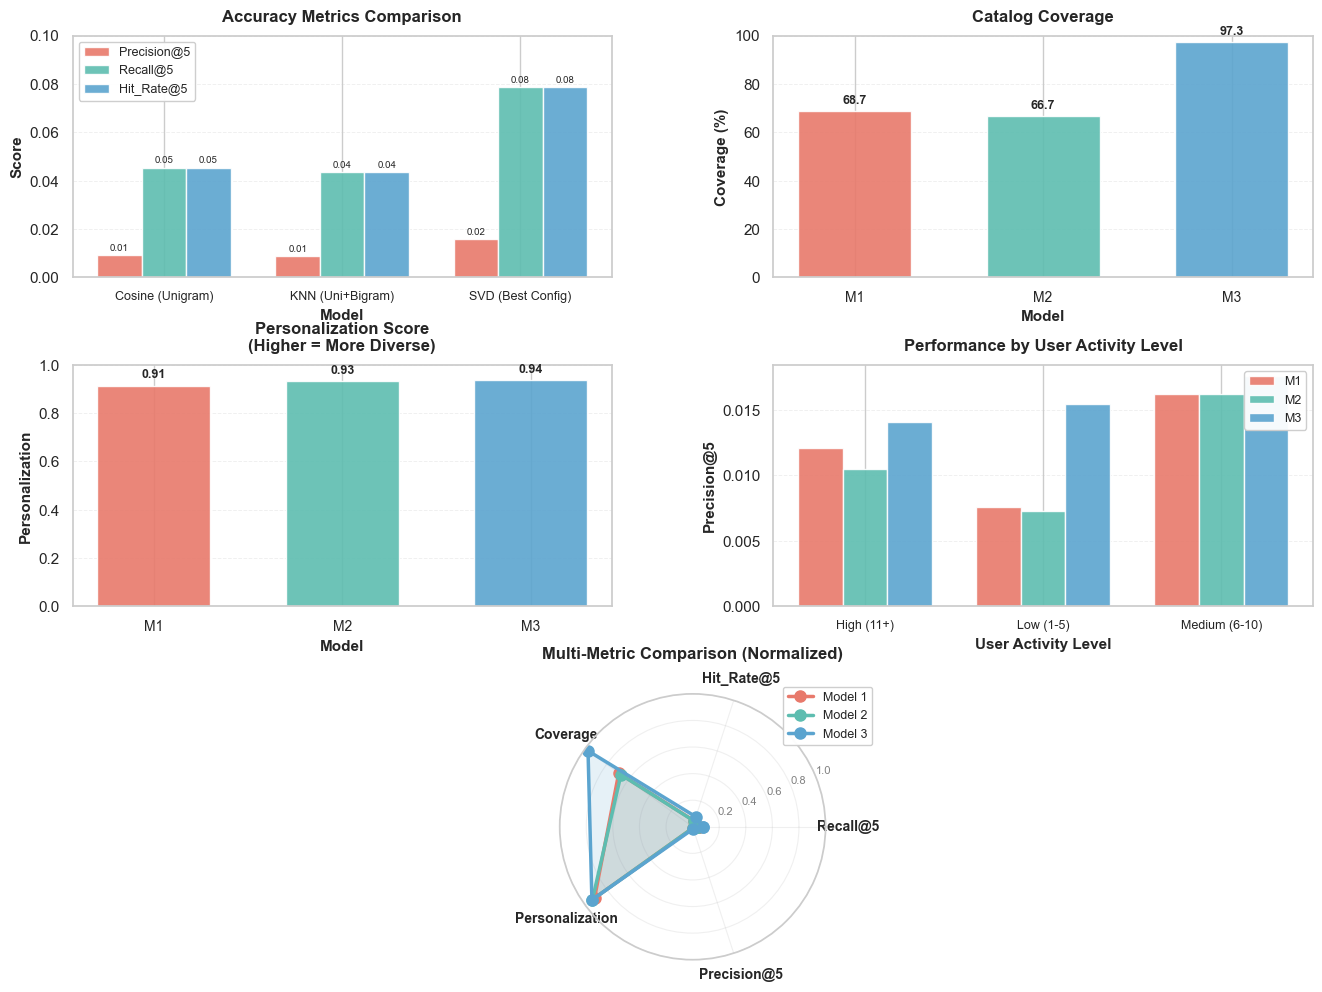


✓ Visualization dashboard created successfully

Dashboard Components:
  1. Accuracy Metrics (Precision, Recall, Hit Rate)
  2. Catalog Coverage (% of items recommended)
  3. Personalization (recommendation diversity)
  4. User Activity Analysis (performance by segment)
  5. Radar Chart (holistic multi-metric view)


In [51]:
print("\n" + "="*80)
print("CREATING VISUALIZATION DASHBOARD")
print("="*80)

# Set up figure with 3-row, 2-column layout
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.30, height_ratios=[1, 1, 1.1])

# Color palette (coral, teal, blue)
colors = ['#E8796B', '#5DBDB0', '#5BA4CF']
model_labels = results_df['Model'].tolist()

# ===== Plot 1: Accuracy Metrics Comparison =====
ax1 = fig.add_subplot(gs[0, 0])
metrics_to_plot = ['Precision@5', 'Recall@5', 'Hit_Rate@5']
x_pos = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    ax1.bar(x_pos + i * width, results_df[metric], width, 
            label=metric, alpha=0.9, color=colors[i])

ax1.set_xlabel('Model', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Accuracy Metrics Comparison', fontsize=12, fontweight='bold', pad=10)
ax1.set_xticks(x_pos + width)
ax1.set_xticklabels(model_labels, fontsize=9)
ax1.legend(loc='upper left', framealpha=0.95, fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax1.set_ylim(0, max(results_df[metrics_to_plot].max().max() * 1.2, 0.1))

# Add value labels
for i, metric in enumerate(metrics_to_plot):
    for j, v in enumerate(results_df[metric]):
        if v > 0:
            ax1.text(j + i * width, v + 0.001, f'{v:.2f}', 
                    ha='center', va='bottom', fontsize=7)

# ===== Plot 2: Catalog Coverage =====
ax2 = fig.add_subplot(gs[0, 1])
coverage_values = results_df['Catalog_Coverage']
bars = ax2.bar(range(len(results_df)), coverage_values, 
               color=colors, alpha=0.9, width=0.6)
ax2.set_xlabel('Model', fontsize=11, fontweight='bold')
ax2.set_ylabel('Coverage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Catalog Coverage', fontsize=12, fontweight='bold', pad=10)
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels([f'M{i+1}' for i in range(len(results_df))], fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax2.set_ylim(0, 100)

for i, (bar, val) in enumerate(zip(bars, coverage_values)):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# ===== Plot 3: Personalization Score =====
ax3 = fig.add_subplot(gs[1, 0])
personalization_values = results_df['Personalization']
bars = ax3.bar(range(len(results_df)), personalization_values, 
               color=colors, alpha=0.9, width=0.6)
ax3.set_xlabel('Model', fontsize=11, fontweight='bold')
ax3.set_ylabel('Personalization', fontsize=11, fontweight='bold')
ax3.set_title('Personalization Score\n(Higher = More Diverse)', fontsize=12, fontweight='bold', pad=10)
ax3.set_xticks(range(len(results_df)))
ax3.set_xticklabels([f'M{i+1}' for i in range(len(results_df))], fontsize=10)
ax3.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
ax3.set_ylim(0, 1.0)

for i, (bar, val) in enumerate(zip(bars, personalization_values)):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# ===== Plot 4: Performance by User Activity Level =====
ax4 = fig.add_subplot(gs[1, 1])
activity_labels = ['High (11+)', 'Low (1-5)', 'Medium (6-10)']
x_pos_act = np.arange(len(activity_labels))
width_act = 0.25

for i in range(len(results_df)):
    values = [
        results_df['High_Activity_Precision'].iloc[i],
        results_df['Low_Activity_Precision'].iloc[i],
        results_df['Medium_Activity_Precision'].iloc[i]
    ]
    ax4.bar(x_pos_act + i * width_act, values, width_act, 
            label=f'M{i+1}', alpha=0.9, color=colors[i])

ax4.set_xlabel('User Activity Level', fontsize=11, fontweight='bold')
ax4.set_ylabel('Precision@5', fontsize=11, fontweight='bold')
ax4.set_title('Performance by User Activity Level', fontsize=12, fontweight='bold', pad=10)
ax4.set_xticks(x_pos_act + width_act)
ax4.set_xticklabels(activity_labels, fontsize=9)
ax4.legend(loc='upper right', framealpha=0.95, fontsize=9)
ax4.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

# ===== Plot 5: Radar Chart (Multi-Metric Comparison) =====
ax5 = fig.add_subplot(gs[2, :], projection='polar')

categories = ['Recall@5', 'Hit_Rate@5', 'Coverage', 'Personalization', 'Precision@5']
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

for i, row in results_df.iterrows():
    values = [
        row['Recall@5'],
        row['Hit_Rate@5'],
        row['Catalog_Coverage'] / 100.0,  # Normalize to [0,1]
        row['Personalization'],
        row['Precision@5']
    ]
    values += values[:1]
    
    ax5.plot(angles, values, 'o-', linewidth=2.5, label=f'Model {i+1}', 
             color=colors[i], markersize=8)
    ax5.fill(angles, values, alpha=0.15, color=colors[i])

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, size=10, fontweight='bold')
ax5.set_ylim(0, 1)
ax5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax5.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8, color='gray')
ax5.set_title('Multi-Metric Comparison (Normalized)', 
              fontsize=12, fontweight='bold', pad=25)
ax5.legend(loc='upper right', bbox_to_anchor=(1.20, 1.05), 
          framealpha=0.95, fontsize=9)
ax5.grid(True, alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Visualization dashboard created successfully")
print("="*80)
print(f"\nDashboard Components:")
print(f"  1. Accuracy Metrics (Precision, Recall, Hit Rate)")
print(f"  2. Catalog Coverage (% of items recommended)")
print(f"  3. Personalization (recommendation diversity)")
print(f"  4. User Activity Analysis (performance by segment)")
print(f"  5. Radar Chart (holistic multi-metric view)")
print("="*80)

## 3.2. Collaborative Filtering

In [52]:
def leave_one_out_split(df, user_col='user_id', item_col='vroot_id', min_interactions=2):
    """
    Performs a leave-one-out split for recommendation system evaluation.

    Args:
        df (pd.DataFrame): Input dataframe containing user-item interactions
        user_col (str): Name of the user ID column
        item_col (str): Name of the item ID column
        min_interactions (int): Minimum number of interactions a user must have to be included in validation

    Returns:
        tuple: (train_pivot, val_ground_truth, df_train_split, df_val)
            - train_pivot (pd.DataFrame): Binary user-item matrix for training
            - val_ground_truth (dict): Dictionary mapping user IDs to list of validation items
            - df_train_split (pd.DataFrame): Training dataframe (without validation items)
            - df_val (pd.DataFrame): Validation dataframe (one item per user)
    """
    # Ensure IDs are strings
    df = df.copy()
    df[user_col] = df[user_col].astype(str)
    df[item_col] = df[item_col].astype(str)

    # Identify users with at least min_interactions for Leave-One-Out split
    user_counts = df.groupby(user_col).size()
    valid_val_users = user_counts[user_counts >= min_interactions].index

    # Create Validation split (last interaction per user)
    df_val = df[df[user_col].isin(valid_val_users)].groupby(user_col).tail(1)
    df_train_split = df.drop(df_val.index)

    # Create Training Pivot (binary user-item matrix)
    train_pivot = df_train_split.pivot_table(
        index=user_col,
        columns=item_col,
        aggfunc='size',
        fill_value=0
    )
    train_pivot = (train_pivot > 0).astype(np.float32)

    # Create Validation Ground Truth
    val_ground_truth = df_val.groupby(user_col)[item_col].apply(list).to_dict()

    print(f"Split complete: {len(train_pivot)} users in training, {len(val_ground_truth)} users for validation.")
    print(f"Sample validation users: {list(val_ground_truth.items())[:3]}")

    return train_pivot, val_ground_truth, df_train_split, df_val

# Perform leave-one-out split
train_tuning_pivot, val_ground_truth, df_train_split, df_val = leave_one_out_split(
    df_train,
    user_col='user_id',
    item_col='vroot_id',
    min_interactions=2
)

Split complete: 32711 users in training, 22716 users for validation.
Sample validation users: [('10001', ['1002']), ('10002', ['1003']), ('10003', ['1004'])]


In [53]:
def check_split_integrity(train_pivot, val_ground_truth):
    print("--- Split Integrity Check  ---")

    # Standardize everything to strings
    train_pivot.index = train_pivot.index.astype(str)
    val_users = [str(u) for u in val_ground_truth.keys()]

    #Check presence in index
    train_indices = set(train_pivot.index)
    users_in_index = [u for u in val_users if u in train_indices]

    # Check for non-zero rows
    # We use .values.sum(axis=1) to avoid any index alignment issues during the sum
    subset = train_pivot.loc[users_in_index]
    row_sums = subset.values.sum(axis=1)
    users_with_history = (row_sums > 0).sum()

    print(f"Total Validation Users:          {len(val_users)}")
    print(f"Users found in Training Index:   {len(users_in_index)}")
    print(f"Users with >0 Training items:    {users_with_history}")

    if users_with_history < 200:
        print("\n[CRITICAL] Almost no validation users have training history.")
        print("Check if you used a 'Leave-One-Out' split that accidentally deleted the user's entire history.")

check_split_integrity(train_tuning_pivot, val_ground_truth)

--- Split Integrity Check  ---
Total Validation Users:          22716
Users found in Training Index:   22716
Users with >0 Training items:    22716


In [54]:
class KNNRecommender:
    def __init__(self, k_vals=[5, 10, 20, 50]):
        self.k_vals = k_vals
        self.best_k = {'user': 50, 'item': 5}

    def tune(self, pivot, ground_truth, mode='user'):
        best_k, max_score = 0, -1
        print(f"\n--- Tuning {mode.upper()}-Based KNN ---")

        data = pivot.values if mode == 'user' else pivot.T.values
        sparse_data = csr_matrix(data)

        for k in self.k_vals:
            print(f"  Evaluating K={k}...", end=" ", flush=True)
            knn = NearestNeighbors(n_neighbors=k+1, metric='cosine', algorithm='brute').fit(sparse_data)
            recs = {}

            if mode == 'user':
                for u_id in ground_truth.keys():
                    u_idx = pivot.index.get_loc(str(u_id))
                    _, idx = knn.kneighbors(sparse_data[u_idx], n_neighbors=k+1)
                    neighbor_indices = idx.flatten()[1:]
                    scores = pivot.iloc[neighbor_indices].sum(axis=0)
                    scores[pivot.iloc[u_idx] > 0] = -1
                    recs[str(u_id)] = [str(i) for i in scores.sort_values(ascending=False).head(5).index]
            else:
                sim_graph = knn.kneighbors_graph(sparse_data, mode='connectivity')
                for u_id in ground_truth.keys():
                    u_idx = pivot.index.get_loc(str(u_id))
                    seen_indices = np.where(pivot.iloc[u_idx] > 0)[0]
                    item_scores = sim_graph[seen_indices].sum(axis=0).A1
                    item_scores[seen_indices] = -1
                    recs[str(u_id)] = [str(pivot.columns[i]) for i in np.argsort(item_scores)[::-1][:5]]

            metrics = calculate_metrics_at_k(recs, ground_truth, k=5)
            score = sum(metrics.values())
            print(f"Score: {score:.5f}")
            if score > max_score:
                max_score, best_k = score, k

        self.best_k[mode] = best_k
        return best_k

In [55]:

from scipy.sparse import csr_matrix
import implicit

class ALSRecommender:
    def __init__(self, factors_list=[32, 64, 128], reg_list=[0.01, 0.1, 1.0]):
        self.factors_list = factors_list
        self.reg_list = reg_list
        self.best_params = {'factors': 64, 'reg': 0.1}
        self.final_model = None

    def tune(self, train_pivot, val_ground_truth):
        print(f"\n--- Tuning ALS ---")

        # 1. Enforce string types and capture dimensions
        train_pivot.index = train_pivot.index.astype(str)
        train_pivot.columns = train_pivot.columns.astype(str)

        item_list = np.array(train_pivot.columns.tolist())
        user_list = train_pivot.index.tolist()
        num_items = len(item_list)

        # 2. Create Sparse Matrix
        train_sparse = csr_matrix(train_pivot.values.astype('float32'))

        tuning_results = []

        for f in self.factors_list:
            for r in self.reg_list:
                model = implicit.als.AlternatingLeastSquares(
                    factors=f,
                    regularization=r,
                    iterations=20,
                    random_state=42,
                    use_gpu=False
                )


                model.fit(train_sparse, show_progress=False)

                # 3. Generate recommendations one user at a time
                recs_dict = {}
                for idx, u_id in enumerate(user_list):
                    try:
                        # Pass single user's interaction vector
                        ids, _ = model.recommend(
                            idx,
                            train_sparse[idx],
                            N=5,
                            filter_already_liked_items=True
                        )

                        recs_dict[u_id] = item_list[ids].tolist()
                    except Exception as e:
                        recs_dict[u_id] = []

                metrics = calculate_metrics_at_k(recs_dict, val_ground_truth, k=5)
                score = sum(metrics.values())

                print(f"Factors: {f:3} | Reg: {r:4} | Score: {score:.5f}")
                tuning_results.append({'params': {'factors': f, 'reg': r}, 'score': score})

        self.best_params = max(tuning_results, key=lambda x: x['score'])['params']
        return self.best_params

ModuleNotFoundError: No module named 'implicit'

In [ ]:
# Initialize And Fine-tune KNN
knn_engine = KNNRecommender()

knn_engine.tune(train_tuning_pivot, val_ground_truth, mode='user')
knn_engine.tune(train_tuning_pivot, val_ground_truth, mode='item')

In [ ]:
# Initialize And Fine-tune ALS
als_engine = ALSRecommender()
als_engine.tune(train_tuning_pivot, val_ground_truth)

In [ ]:
# Setup for Final Predictions
full_pivot = (train_binary > 0).astype(np.float32)
item_list = full_pivot.columns.tolist()
user_sparse_full = csr_matrix(full_pivot.values)
item_sparse_full = csr_matrix(full_pivot.T.values)

# Retrain Final Models On Full Train Dataset
knn_user_final = NearestNeighbors(
    n_neighbors=knn_engine.best_k['user']+1,
    metric='cosine'
).fit(user_sparse_full)

knn_item_final = NearestNeighbors(
    n_neighbors=knn_engine.best_k['item']+1,
    metric='cosine'
).fit(item_sparse_full)

item_sim_graph = knn_item_final.kneighbors_graph(item_sparse_full, mode='connectivity')


final_als = implicit.als.AlternatingLeastSquares(
    factors=als_engine.best_params['factors'],
    regularization=als_engine.best_params['reg'],
    iterations=30,
    random_state=42
)

final_als.fit(user_sparse_full, show_progress=True)

# 4. Generate Predictions for All Test Users
user_based_map, item_based_map, als_recs = {}, {}, {}

for user_id in X_test_tfidf.index:
    u_str = str(user_id)
    if u_str in full_pivot.index:
        u_idx = full_pivot.index.get_loc(u_str)
        seen_indices = np.where(full_pivot.iloc[u_idx] > 0)[0]

        # User-Based KNN
        _, u_neighbors = knn_user_final.kneighbors(
            user_sparse_full[u_idx],
            n_neighbors=knn_engine.best_k['user']+1
        )
        u_scores = full_pivot.iloc[u_neighbors.flatten()[1:]].sum(axis=0)
        u_scores[full_pivot.iloc[u_idx] > 0] = -1
        user_based_map[u_str] = [str(i) for i in u_scores.sort_values(ascending=False).head(5).index]

        # Item-Based KNN
        i_scores = item_sim_graph[seen_indices].sum(axis=0).A1
        i_scores[seen_indices] = -1
        item_based_map[u_str] = [str(item_list[i]) for i in np.argsort(i_scores)[::-1][:5]]

        # ALS
        try:
            ids, _ = final_als.recommend(
                u_idx,
                user_sparse_full[u_idx],
                N=5,
                filter_already_liked_items=False
            )
            als_recs[u_str] = [str(item_list[i]) for i in ids]
        except Exception as e:
            print(f"Error generating ALS recs for user {u_str}: {e}")
            als_recs[u_str] = []

    else:
        user_based_map[u_str] = item_based_map[u_str] = als_recs[u_str] = global_top_5


print("All recommendation maps generated successfully.")

In [ ]:
print(calculate_metrics_at_k(user_based_map, ground_truth, k = 5))

In [ ]:
print(calculate_metrics_at_k(item_based_map, ground_truth, k = 5))

In [ ]:
print(calculate_metrics_at_k(als_recs, ground_truth, k = 5))

## 3.3. Hybrid Approach

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
from scipy import stats
import time
from math import pi
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ==========================================================
# 1. DATA PREPARATION
# ==========================================================

print("\n" + "="*80)
print("Step 1: DATA PREPARATION")
print("="*80)

# Load data
X_train_tfidf = pd.read_csv('task2_train_features.csv', index_col='user_id')
train_binary  = pd.read_csv('train_binary_matrix.csv', index_col='user_id')
item_popularity_series = pd.read_csv('item_popularity.csv', index_col=0).squeeze(True)
item_sim_df = pd.read_csv('item_similarity_matrix.csv', index_col=0)
df_test = pd.read_csv('cleaned_test.csv')

# Convert IDs to strings
X_train_tfidf.index = X_train_tfidf.index.astype(str)
X_train_tfidf.columns = X_train_tfidf.columns.astype(str)

train_binary.index = train_binary.index.astype(str)
train_binary.columns = train_binary.columns.astype(str)

item_sim_df.index = item_sim_df.index.astype(str)
item_sim_df.columns = item_sim_df.columns.astype(str)

df_test['user_id'] = df_test['user_id'].astype(str)
df_test['vroot_id'] = df_test['vroot_id'].astype(str)

item_popularity_series.index = item_popularity_series.index.astype(str)

# Check overlap with training
test_user_ids = df_test['user_id'].unique()
train_user_set = set(train_binary.index)
test_user_set = set(test_user_ids)

users_in_both = test_user_set & train_user_set
users_only_test = test_user_set - train_user_set

print(f"  Users in both train & test: {len(users_in_both)} ({len(users_in_both)/len(test_user_ids)*100:.1f}%)")
print(f"  New users (cold start): {len(users_only_test)} ({len(users_only_test)/len(test_user_ids)*100:.1f}%)")


# Build test features from training profiles
X_test_tfidf_rows = []

for user_id in test_user_ids:
    user_str = str(user_id)

    if user_str in X_train_tfidf.index:
        # User exists in training - use their TRAINING TF-IDF profile
        user_profile = X_train_tfidf.loc[user_str]
    else:
        # Cold start user - use ZERO profile
        user_profile = pd.Series(0, index=X_train_tfidf.columns)

    X_test_tfidf_rows.append(user_profile)

# Create DataFrame
X_test_tfidf = pd.DataFrame(
    X_test_tfidf_rows,
    index=[str(u) for u in test_user_ids],
    columns=X_train_tfidf.columns
)

item_popularity = item_popularity_series.to_dict()

print(f'Training users: {len(train_binary)}')
print(f'Test users: {len(X_test_tfidf)}')
print(f'Items: {len(X_train_tfidf.columns)}')


Step 1: DATA PREPARATION
  Users in both train & test: 5000 (100.0%)
  New users (cold start): 0 (0.0%)
Training users: 32711
Test users: 5000
Items: 183


In [ ]:
# ==========================================================
# 2. PREPARE STACKING DATA
# ==========================================================

print("\n" + "="*80)
print("Step 2: PREPARE STACKING DATA")
print("="*80)

def prepare_stacking_data(train_binary, item_popularity, item_sim_df, neg_ratio=3):
    np.random.seed(42)
    stack_features = []
    stack_labels = []

    pos_users, pos_items = np.where(train_binary.values == 1)
    n_positives = len(pos_users)

    # Normalize popularity
    max_pop = max(item_popularity.values())
    max_items = train_binary.shape[1]

    # Positive samples
    for idx in range(n_positives):
        u_id = train_binary.index[pos_users[idx]]
        i_id = train_binary.columns[pos_items[idx]]

        f1 = train_binary.loc[u_id].sum() / max_items
        f2 = item_popularity[i_id] / max_pop

        user_history = train_binary.columns[train_binary.loc[u_id] > 0]
        other_items = [item for item in user_history if item != i_id]
        f3 = item_sim_df.loc[other_items, i_id].mean() if len(other_items) > 0 else 0

        stack_features.append([f1, f2, f3])
        stack_labels.append(1)

    # Negatives
    target_neg = n_positives * neg_ratio
    neg_count = 0
    positive_pairs = set(zip(pos_users, pos_items))

    while neg_count < target_neg:
        u_idx = np.random.randint(0, train_binary.shape[0])
        i_idx = np.random.randint(0, train_binary.shape[1])

        if (u_idx, i_idx) not in positive_pairs:
            u_id = train_binary.index[u_idx]
            i_id = train_binary.columns[i_idx]

            f1 = train_binary.loc[u_id].sum() / max_items
            f2 = item_popularity[i_id] / max_pop

            user_history = train_binary.columns[train_binary.loc[u_id] > 0]
            f3 = item_sim_df.loc[user_history, i_id].mean() if len(user_history) > 0 else 0

            stack_features.append([f1, f2, f3])
            stack_labels.append(0)
            neg_count += 1

    return np.array(stack_features), np.array(stack_labels)

X_stack, y_stack = prepare_stacking_data(train_binary, item_popularity, item_sim_df, neg_ratio=3)   
print(f"Dataset: {len(y_stack):,} samples ({sum(y_stack):,} positive, {len(y_stack)-sum(y_stack):,} negative)")


Step 2: PREPARE STACKING DATA
Dataset: 391,892 samples (97,973 positive, 293,919 negative)


In [ ]:
# ==========================================================
# 3. TRAIN STACKING MODEL
# ==========================================================

print("\n" + "="*80)
print("Step 3: TRAIN STACKING MODEL")
print("="*80)

# Define parameter grids
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [5, 10]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'max_iter': [1000]
    }
}

def train_model(model, param_grid, X, y, name): 
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=0, return_train_score=True)
    grid_search.fit(X, y)

    # Overfitting check
    best_idx = grid_search.best_index_
    train_score = grid_search.cv_results_['mean_train_score'][best_idx]
    val_score = grid_search.cv_results_['mean_test_score'][best_idx]
    print(f"Train F1: {train_score:.4f}, Val F1: {val_score:.4f}, Gap: {train_score - val_score:.4f}")

    if train_score - val_score > 0.1:
        print(f"Significant overfitting detected for {name}.")
    elif train_score - val_score > 0.05:
        print(f"Moderate overfitting detected for {name}.")
    else: 
        print(f"Good generalization for {name}.")
    
    # Feature importance
    if hasattr(grid_search.best_estimator_, 'feature_importances_'):
        importances = grid_search.best_estimator_.feature_importances_
        print(f"Feature importance: User Activity={importances[0]:.4f}, Item Popularity={importances[1]:.4f}, Item Similarity={importances[2]:.4f}")

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    print(f"Best {name} with F1 score: {best_score:.4f} with params: {grid_search.best_params_}")
    return best_model


Step 3: TRAIN STACKING MODEL


In [ ]:
# Combination 1: RandomForest + GradientBoosting / LogisticRegression
print("\n" + "="*70)
print("Combination 1: RandomForest + GradientBoosting / LogisticRegression")
print("="*70)

rf1 = train_model(RandomForestClassifier(random_state=42), param_grids['RandomForest'], X_stack, y_stack, 'RandomForest')
gb1 = train_model(GradientBoostingClassifier(random_state=42), param_grids['GradientBoosting'], X_stack, y_stack, 'GradientBoosting')
stacking1 = StackingClassifier(
    estimators=[('rf', rf1), ('gb', gb1)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1,
    cv=3
)
stacking1.fit(X_stack, y_stack)
print('Combination 1 trained')


Combination 1: RandomForest + GradientBoosting / LogisticRegression

Training RandomForest...
Train F1: 0.8565, Val F1: 0.8518, Gap: 0.0047
Good generalization for RandomForest.
Feature importance: User Activity=0.1341, Item Popularity=0.4128, Item Similarity=0.4531
Best RandomForest with F1 score: 0.8518 with params: {'max_depth': 10, 'n_estimators': 100}

Training GradientBoosting...
Train F1: 0.8518, Val F1: 0.8496, Gap: 0.0022
Good generalization for GradientBoosting.
Feature importance: User Activity=0.1637, Item Popularity=0.1836, Item Similarity=0.6527
Best GradientBoosting with F1 score: 0.8496 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Combination 1 trained


In [ ]:
# Combination 2: KNN + XGB + GB / LogisticRegression
print("\n" + "="*70)
print("Combination 2: KNN + XGB + GB / LogisticRegression")
print("="*70)

knn2 = train_model(KNeighborsClassifier(), param_grids['KNN'], X_stack, y_stack, 'KNN')
xgb2 = train_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grids['XGBoost'], X_stack, y_stack, 'XGBoost')
gb2 = train_model(GradientBoostingClassifier(random_state=42), param_grids['GradientBoosting'], X_stack, y_stack, 'GradientBoosting')
stacking2 = StackingClassifier(
    estimators=[('knn', knn2), ('xgb', xgb2), ('gb', gb2)],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    n_jobs=-1,
    cv=3
)
stacking2.fit(X_stack, y_stack)
print('Combination 2 trained')


Combination 2: KNN + XGB + GB / LogisticRegression

Training KNN...
Train F1: 0.9703, Val F1: 0.8476, Gap: 0.1227
Significant overfitting detected for KNN.
Best KNN with F1 score: 0.8476 with params: {'n_neighbors': 7, 'weights': 'distance'}

Training XGBoost...
Train F1: 0.8477, Val F1: 0.8464, Gap: 0.0013
Good generalization for XGBoost.
Feature importance: User Activity=0.2176, Item Popularity=0.2281, Item Similarity=0.5542
Best XGBoost with F1 score: 0.8464 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Training GradientBoosting...
Train F1: 0.8518, Val F1: 0.8496, Gap: 0.0022
Good generalization for GradientBoosting.
Feature importance: User Activity=0.1637, Item Popularity=0.1836, Item Similarity=0.6527
Best GradientBoosting with F1 score: 0.8496 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Combination 2 trained


In [ ]:
# Combination 3: LR + RF + XGB / XGB
print("\n" + "="*70)
print("Combination 3: LR + RF + XGB / XGB")
print("="*70)

lr3 = train_model(LogisticRegression(max_iter=1000, random_state=42), param_grids['LogisticRegression'], X_stack, y_stack, 'LogisticRegression')
rf3 = train_model(RandomForestClassifier(random_state=42), param_grids['RandomForest'], X_stack, y_stack, 'RandomForest')
xgb3 = train_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grids['XGBoost'], X_stack, y_stack, 'XGBoost')
stacking3 = StackingClassifier(
    estimators=[('lr', lr3), ('rf', rf3), ('xgb', xgb3)],
    final_estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    n_jobs=-1,
    cv=3
)
stacking3.fit(X_stack, y_stack)
print('Combination 3 trained')


Combination 3: LR + RF + XGB / XGB

Training LogisticRegression...
Train F1: 0.7568, Val F1: 0.7566, Gap: 0.0002
Good generalization for LogisticRegression.
Best LogisticRegression with F1 score: 0.7566 with params: {'C': 10, 'max_iter': 1000}

Training RandomForest...
Train F1: 0.8565, Val F1: 0.8518, Gap: 0.0047
Good generalization for RandomForest.
Feature importance: User Activity=0.1341, Item Popularity=0.4128, Item Similarity=0.4531
Best RandomForest with F1 score: 0.8518 with params: {'max_depth': 10, 'n_estimators': 100}

Training XGBoost...
Train F1: 0.8477, Val F1: 0.8464, Gap: 0.0013
Good generalization for XGBoost.
Feature importance: User Activity=0.2176, Item Popularity=0.2281, Item Similarity=0.5542
Best XGBoost with F1 score: 0.8464 with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Combination 3 trained


In [ ]:
# ==========================================================
# 4. GENERATE RECOMMENDATIONS
# ==========================================================

print("\n" + "="*80)
print("Step 4: GENERATING RECOMMENDATIONS")
print("="*80)

def get_candidates(user_str, train_binary, item_sim_df, item_popularity, X_test_tfidf, n_candidates=100):
    scored_candidates = {}

    # Strategy 1: Collaborative (Weight 1.0)
    if user_str in train_binary.index:
        user_hist = train_binary.columns[train_binary.loc[user_str] > 0]
        if len(user_hist) > 0:
            sim_scores = item_sim_df.loc[:, user_hist].mean(axis=1).sort_values(ascending=False).head(40)
            for i, (idx, score) in enumerate(sim_scores.items()):
                scored_candidates[idx] = scored_candidates.get(idx, 0) + (1.0 - (i/40))

    # Strategy 2: Content-Based (Weight 1.0)
    if user_str in X_test_tfidf.index:
        content_scores = X_test_tfidf.loc[user_str].sort_values(ascending=False).head(40)
        for i, (idx, score) in enumerate(content_scores.items()):
            # Only add if score > 0 to avoid adding random 0-score items
            if score > 0:
                scored_candidates[idx] = scored_candidates.get(idx, 0) + (1.0 - (i/40))

    # Strategy 3: Popularity Fallback
    pop_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)[:40]
    for i, (idx, count) in enumerate(pop_items):
        scored_candidates[idx] = scored_candidates.get(idx, 0) + (0.5 - (i/80)) # Lower weight for pop

    # Sort by combined heuristic and take top N
    final_candidates = sorted(scored_candidates.items(), key=lambda x: x[1], reverse=True)
    return [item[0] for item in final_candidates[:n_candidates]]


def generate_recommendations(stacking_model, user_str, candidates, train_binary, item_popularity, item_sim_df, top_n=5):
    """
    Generate top-N recommendations using stacking model.
    """
    # Extract features for all candidates
    cand_features = []
    valid_candidates = []
    max_pop = max(item_popularity.values())
    max_items = train_binary.shape[1]

    for i_id in candidates:
        f1 = train_binary.loc[user_str].sum() / max_items if user_str in train_binary.index else 0
        f2 = item_popularity.get(i_id, 0) / max_pop

        if user_str in train_binary.index:
            user_history = train_binary.columns[train_binary.loc[user_str] > 0]
            other_items = [item for item in user_history if item != i_id]
            f3 = item_sim_df.loc[other_items, i_id].mean() if len(other_items) > 0 and i_id in item_sim_df.columns else 0
        else: 
            f3 = 0
        
        cand_features.append([f1, f2, f3])
        valid_candidates.append(i_id)

    if len(cand_features) == 0:
        return [item[0] for item in sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)[:top_n]]

    # Get predictions
    X_cand = np.array(cand_features)
    proba = stacking_model.predict_proba(X_cand)[:, 1]

    # Get top-N
    top_indices = np.argsort(proba)[-top_n:][::-1]
    recommendations = [valid_candidates[i] for i in top_indices]

    return recommendations


# Generate recommendations for all combinations
stack_recs_comb1 = {}
stack_recs_comb2 = {}
stack_recs_comb3 = {}
test_users = X_test_tfidf.index.tolist()
total_users = len(test_users)
for idx, user_id in enumerate(test_users):
    if idx % 500 == 0:
        print(f"  Progress: {idx}/{total_users} users ({idx/total_users*100:.1f}%)")

    user_str = str(user_id)

    # Get candidates
    candidates = get_candidates(
        user_str, train_binary, item_sim_df, item_popularity, X_test_tfidf
    )

    # Generate recommendations from all three combinations
    stack_recs_comb1[user_str] = generate_recommendations(
        stacking1, user_str, candidates, train_binary, item_popularity, item_sim_df
    )

    stack_recs_comb2[user_str] = generate_recommendations(
        stacking2, user_str, candidates, train_binary, item_popularity, item_sim_df
    )

    stack_recs_comb3[user_str] = generate_recommendations(
        stacking3, user_str, candidates, train_binary, item_popularity, item_sim_df
    )

print(f"\n✓ Recommendations generated for {total_users} users")


Step 4: GENERATING RECOMMENDATIONS
  Progress: 0/5000 users (0.0%)
  Progress: 500/5000 users (10.0%)
  Progress: 1000/5000 users (20.0%)
  Progress: 1500/5000 users (30.0%)
  Progress: 2000/5000 users (40.0%)
  Progress: 2500/5000 users (50.0%)
  Progress: 3000/5000 users (60.0%)
  Progress: 3500/5000 users (70.0%)
  Progress: 4000/5000 users (80.0%)
  Progress: 4500/5000 users (90.0%)

✓ Recommendations generated for 5000 users


In [ ]:
# ==========================================================
# 5. EVALUATION
# ==========================================================

print("\n" + "="*80)
print("Step 5: EVALUATING MODEL PERFORMANCE")
print("="*80)

print("\nCalculating metrics...")

metrics_list = []

for name, recs in [('Combination 1', stack_recs_comb1),
                         ('Combination 2', stack_recs_comb2),
                         ('Combination 3', stack_recs_comb3)]:
    metrics = calculate_metrics_at_k(recommendations=recs, ground_truth=ground_truth, k=5)
    coverage = calculate_catalog_coverage(recs, len(X_train_tfidf.columns))
    personalization = calculate_personalization(recs)
    metrics_list.append({
        'Model': name,
        'Precision@5': metrics['Precision@5'],
        'Recall@5': metrics['Recall@5'],
        'Hit_Rate@5': metrics['Hit_Rate@5'],
        'Catalog_Coverage': coverage,
        'Personalization': personalization
    })

results_df = pd.DataFrame(metrics_list)
print("\n" + results_df.to_string(index=False))


Step 5: EVALUATING MODEL PERFORMANCE

Calculating metrics...

        Model  Precision@5  Recall@5  Hit_Rate@5  Catalog_Coverage  Personalization
Combination 1      0.15932  0.298438      0.5434         75.409836         0.816813
Combination 2      0.18384  0.346842      0.6076         83.606557         0.677511
Combination 3      0.15028  0.277863      0.5280         74.863388         0.811886


In [ ]:
# ==========================================================
# 6. USER SEGMENT ANALYSIS
# ==========================================================

print("\n" + "="*80)
print("Step 6: USER SEGMENT ANALYSIS")
print("="*80)

segment_results = []
for recs, name in [(stack_recs_comb1, 'Combination 1'),
                   (stack_recs_comb2, 'Combination 2'),
                   (stack_recs_comb3, 'Combination 3')]:
    segment_analysis = analyze_by_user_activity(recs, ground_truth, train_binary)
    for segment_name in ['Low Activity (1-5)', 'Medium Activity (6-10)', 'High Activity (11+)']:
        segment_results.append({
            'Model': name,
            'Segment': segment_name,
            'N_Users': segment_analysis[segment_name]['count'],
            'Precision': segment_analysis[segment_name]['precision']
        })

segment_df = pd.DataFrame(segment_results)
pivot_df = segment_df.pivot(index='Segment', columns='Model', values='Precision')
print("\n" + pivot_df.to_string())


Step 6: USER SEGMENT ANALYSIS

Model                   Combination 1  Combination 2  Combination 3
Segment                                                            
High Activity (11+)          0.169231       0.145055       0.131868
Low Activity (1-5)           0.154845       0.184994       0.146835
Medium Activity (6-10)       0.192199       0.181206       0.179787



Step 7: GENERATING VISUALIZATIONS


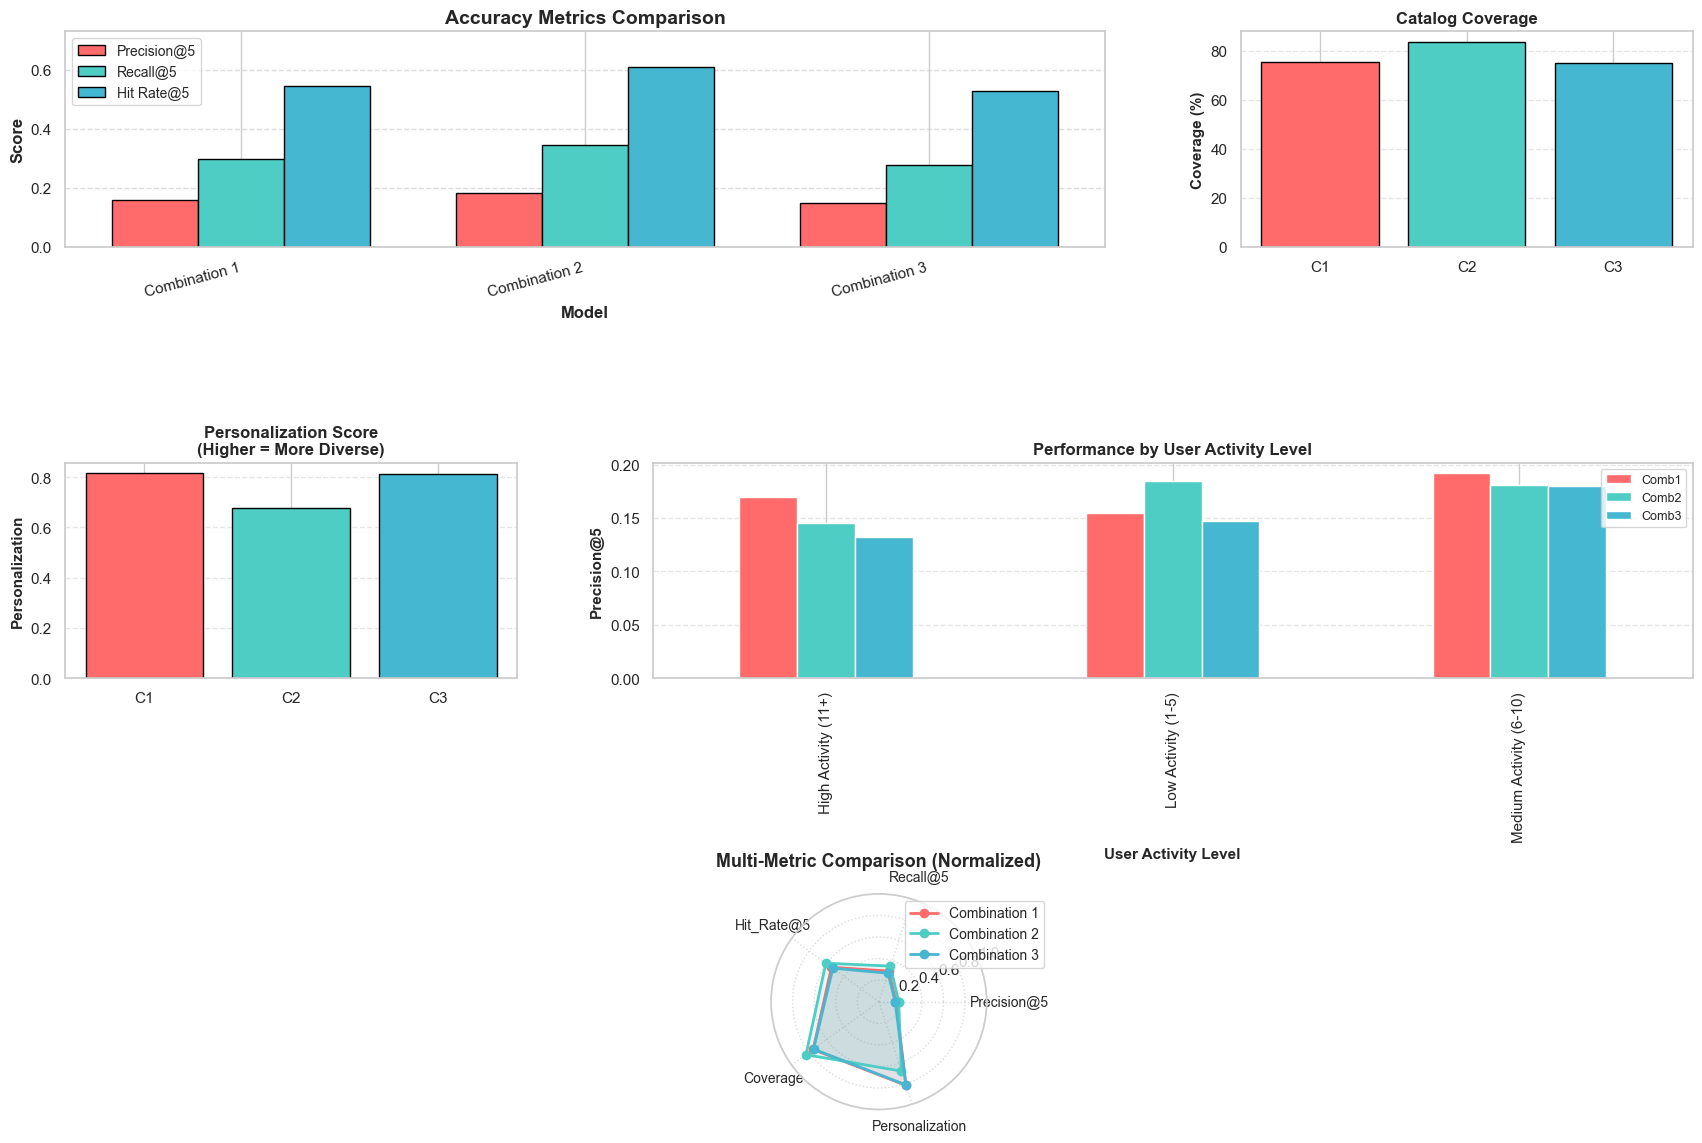


✓ Comprehensive visualization saved: comprehensive_stacking_evaluation.png


In [ ]:
# ==========================================================
# 7. RESULT VISUALIZATION
# ==========================================================

print("\n" + "="*80)
print("Step 7: GENERATING VISUALIZATIONS")
print("="*80)

# Set style
sns.set_style("whitegrid")

# Create comprehensive comparison figure
fig = plt.figure(figsize=(21, 14))
gs = fig.add_gridspec(3, 3, hspace=1.0, wspace=0.3)

# Plot 1: Accuracy Metrics Comparison
ax1 = fig.add_subplot(gs[0, :2])
x = np.arange(len(results_df))
width = 0.25
ax1.bar(x - width, results_df['Precision@5'], width, label='Precision@5', color='#FF6B6B', edgecolor='black')
ax1.bar(x, results_df['Recall@5'], width, label='Recall@5', color='#4ECDC4', edgecolor='black')
ax1.bar(x + width, results_df['Hit_Rate@5'], width, label='Hit Rate@5', color='#45B7D1', edgecolor='black')
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], rotation=15, ha='right')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, max(results_df[['Precision@5', 'Recall@5', 'Hit_Rate@5']].max()) * 1.2)

# Plot 2: Catalog Coverage
ax2 = fig.add_subplot(gs[0, 2])
bars = ax2.bar(range(len(results_df)), results_df['Catalog_Coverage'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
ax2.set_ylabel('Coverage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Catalog Coverage', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(['C1', 'C2', 'C3'])
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 3: Personalization Score
ax3 = fig.add_subplot(gs[1, 0])
bars = ax3.bar(range(len(results_df)), results_df['Personalization'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
ax3.set_ylabel('Personalization', fontsize=11, fontweight='bold')
ax3.set_title('Personalization Score\n(Higher = More Diverse)', fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(results_df)))
ax3.set_xticklabels(['C1', 'C2', 'C3'])
ax3.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 4: User Segment Performance
ax4 = fig.add_subplot(gs[1, 1:])
pivot_df.plot(kind='bar', ax=ax4, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax4.set_title('Performance by User Activity Level', fontsize=12, fontweight='bold')
ax4.set_xlabel('User Activity Level', fontsize=11, fontweight='bold')
ax4.set_ylabel('Precision@5', fontsize=11, fontweight='bold')
ax4.legend(['Comb1', 'Comb2', 'Comb3'], loc='upper right', fontsize=9)
ax4.grid(axis='y', linestyle='--', alpha=0.5)

# Plot 5: Radar Chart
ax5 = fig.add_subplot(gs[2, :], projection='polar')
categories = ['Precision@5', 'Recall@5', 'Hit_Rate@5', 'Coverage', 'Personalization']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
labels = ['Combination 1', 'Combination 2', 'Combination 3']
for i, (color, label) in enumerate(zip(colors, labels)):
    values = []
    for col in ['Precision@5', 'Recall@5', 'Hit_Rate@5', 'Catalog_Coverage', 'Personalization']:
        if col == 'Catalog_Coverage':
            values.append(results_df.iloc[i][col] / 100)  # Normalize to 0-1
        else:
            values.append(results_df.iloc[i][col])
    values += values[:1]

    ax5.plot(angles, values, 'o-', linewidth=2, label=label, color=color)
    ax5.fill(angles, values, alpha=0.15, color=color)

ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories, fontsize=10)
ax5.set_ylim(0, 1)
ax5.set_title('Multi-Metric Comparison (Normalized)', fontsize=13, fontweight='bold', pad=20)
ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
ax5.grid(True, linestyle=':', alpha=0.7)

plt.show()
print("\n✓ Comprehensive visualization saved: comprehensive_stacking_evaluation.png")